# Import and settings

In [50]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import logging
import logzero
from logzero import logger


# examination settings
batch_size = 128
test_batch_size = batch_size * 4
momentum = 0.9
seed = 2017
num_workers = 2
use_gpu = False

# set seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# logger setting
LOG_FORMAT = '[%(asctime)s %(levelname)s] %(message)s'
logzero.loglevel(logging.INFO)
logzero.formatter(logging.Formatter(LOG_FORMAT))

# Prepare data

In [51]:
train_dataset = datasets.MNIST('./data/MNIST/train/', download=True, train=True)
test_dataset = datasets.MNIST('./data/MNIST/test/', download=True, train=False)

train_data = train_dataset.train_data.numpy()
test_data = test_dataset.test_data.numpy()
train_labels = train_dataset.train_labels.numpy()
test_labels = test_dataset.test_labels.numpy()

In [52]:
print(len(train_labels), len(test_labels))

60000 10000


# Change the ratio train/test
train:val:test を 1000:1000:68000に設定。各クラスのサンプル数は均一に。testセットは実際に教師なし学習に用いることは想定しづらいので、現実のタスクや論文に書く時はunlabeledデータとして説明すれば良い。その場合はtestセット内で更に unlabeled/holdout に分ける必要がある。
交差検証は行わない。

pseudo label実験に対してはtestデータはunlabeledデータ及び最終評価用のデータとして使われる。valは学習中の精度監視用。

In [55]:
n_train = 1000
n_val = 1000
n_test = 10000
n_unlabeled = 58000

X_train = np.empty(shape=(0, 28, 28))
y_train = np.empty(shape=(0,))
X_val = np.empty(shape=(0, 28, 28))
y_val = np.empty(shape=(0,))
X_test = np.empty(shape=(0, 28, 28))
y_test = np.empty(shape=(0,))

for i in range(10):
    idx_train = np.argwhere(train_labels == i)[:(n_train//10)].squeeze()
    idx_val = np.argwhere(train_labels == i)[(n_train//10):((n_train+n_val)//10)].squeeze()
    idx_test = np.argwhere(train_labels == i)[((n_train+n_val)//10):].squeeze()
    
    X_train = np.concatenate([X_train, train_data[idx_train]], axis=0)
    y_train = np.concatenate([y_train, train_labels[idx_train]], axis=0)
    X_val = np.concatenate([X_val, train_data[idx_val]], axis=0)
    y_val = np.concatenate([y_val, train_labels[idx_val]], axis=0)
    X_test = np.concatenate([X_test, train_data[idx_test]], axis=0)
    y_test = np.concatenate([y_test, train_labels[idx_test]], axis=0)
    
X_test = np.concatenate([X_test, test_data], axis=0)
y_test = np.concatenate([y_test, test_labels], axis=0)

# treat as image
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

# one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1000, 28, 28, 1) (1000, 10) (1000, 28, 28, 1) (1000, 10) (68000, 28, 28, 1) (68000, 10)


## Prepare Pseudo Label

testデータをtest/unlabeledに分ける。
比率は10000:58000とする。（元々のMNISTの提供時点でのtest splitを用いる）

In [37]:
random_idx = np.random.permutation(n_unlabeled)

idx1 = random_idx[:n_unlabeled//2]
idx2 = random_idx[n_unlabeled//2:]

X_unlabeled1 = X_test[idx1]
y_unlabeled1 = y_test[idx1]
X_unlabeled2 = X_test[idx2]
y_unlabeled2 = y_test[idx2]
X_test = X_test[n_unlabeled:]
y_test = y_test[n_unlabeled:]

print(
    X_unlabeled1.shape, y_unlabeled1.shape,
    X_unlabeled2.shape, y_unlabeled2.shape,
    X_test.shape, y_test.shape
)

(29000, 28, 28, 1) (29000, 10) (29000, 28, 28, 1) (29000, 10) (10000, 28, 28, 1) (10000, 10)


# Define a network

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.adaptive_max_pool2d(x, output_size=1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x

# Define Dataset, DataLoader

In [31]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.X[index]
        img = self.transform(img)
        target = torch.Tensor(self.y[index].astype(float))
        return img, target
    
    def __len__(self):
        return len(self.X)


class MNISTDatasetForPseudoLabeling(torch.utils.data.Dataset):
    def __init__(self, X_train, y_train, X_dash, y_dash, ratio_pl, hard, transform):
        self.X_train = X_train
        self.y_train = y_train
        self.X_dash = X_dash
        self.y_dash = y_dash
        self.ratio_pl = ratio_pl
        self.hard = hard
        self.transform = transform
        
    def __getitem__(self, index):
        if index < len(self.X_train):
            img = self.X_train[index]
            target = torch.Tensor(self.y_train[index].astype(float))
        else:
            index = np.random.randint(0, len(self.X_dash))
            img = self.X_dash[index]
            if self.hard:
                hard_label = int(np.argmax(self.y_dash[index]))
                zeros = np.zeros_like(self.y_dash[index])
                zeros[hard_label] = 1.0
                target = torch.Tensor(zeros)
            else:
                target = torch.Tensor(self.y_dash[index].astype(float))
        
        img = self.transform(img)
        return img, target
    
    def __len__(self):
        return int(len(self.X_train) * (1 + ratio_pl))

# Define TrainingTracker

In [32]:
class TrainingTracker(object):
    def __init__(self):
        self.epoch = 0
        self.history = {
            'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []
        }
        self.reset()
        
    def reset(self):
        self.train_acc = 0
        self.train_loss = 0
        self.val_acc = 0
        self.val_loss = 0
        self.train_count = 0
        self.val_count = 0

    def update(self, train, acc, loss, n):
        if train:
            acc_sum = self.train_acc * self.train_count + acc * n
            loss_sum = self.train_loss * self.train_count + loss * n
            self.train_count += n
            self.train_acc = acc_sum / self.train_count
            self.train_loss = loss_sum / self.train_count
        else:
            acc_sum = self.val_acc * self.val_count + acc * n
            loss_sum = self.val_loss * self.val_count + loss * n
            self.val_count += n
            self.val_acc = acc_sum / self.val_count
            self.val_loss = loss_sum / self.val_count

    def plot_history(self):
        plt.plot(self.history['train_acc'])
        plt.plot(self.history['val_acc'])
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['train_acc', 'val_acc'], loc='lower right')
        plt.show()

        plt.plot(self.history['train_loss'])
        plt.plot(self.history['val_loss'])
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['train_loss', 'val_loss'], loc='lower right')
        plt.show()

# Define train, validate, test function

In [33]:
def _train(model, data_loader, criterion, optimizer, tracker):
    model.train()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=True, acc=acc, loss=loss.data[0], n=len(X))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    logger.info(
        'Epoch: {tracker.epoch} | '
        'TrainAcc: {tracker.train_acc:.4f} | '
        'TrainLoss: {tracker.train_loss:.4f}'.format(
            tracker=tracker)
    )
    tracker.history['train_acc'].append(tracker.train_acc)
    tracker.history['train_loss'] .append(tracker.train_loss)
    tracker.reset()

def _validate(model, data_loader, criterion, tracker):
    model.eval()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=False, acc=acc, loss=loss.data[0], n=len(X))

    logger.info(
        'Epoch: {tracker.epoch} | '
        'ValAcc: {tracker.val_acc:.4f} | '
        'ValLoss: {tracker.val_loss:.4f} \n'.format(
            tracker=tracker)
    )
    tracker.history['val_acc'].append(tracker.val_acc)
    tracker.history['val_loss'].append(tracker.val_loss)
    tracker.reset()
    
def _test(model, data_loader, criterion, make_pl=False):
    model.eval()
    
    if make_pl:
        pseudo_label = np.empty((0, 10))
    
    acc_sum = 0
    loss_sum = 0
    n_sample = 0
    for i, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc_sum += pred.eq(answer).sum()
        loss_sum += loss.data[0] * X.size(0)
        n_sample += X.size(0)
        if make_pl:
            pseudo_label = np.concatenate([pseudo_label, output.data.numpy()], axis=0)
    
    if make_pl:
        pseudo_label = np.exp(pseudo_label)
        np.save('./save/pseudo_label_{}.npy'.format(ex_name), pseudo_label)
        
    acc = acc_sum / n_sample
    loss = loss_sum / n_sample
    
    return acc, loss

# Experiments

##  Cross Pseudo Labeling

2fold-cross pseudo label trainingを行う。
この際にpseudo label training に使われない方のunlabeledデータはtestデータと何ら変わらないので、test dataにconcatenationして評価を行う。

[訂正]：やっぱりcross pseudo labelingでunlabeledデータの精度をどこまで高められるかを知りたいのでここでは別々に精度を測る。おそらくほぼ同程度の結果となることが予想される。

[2017-12-05 02:35:23,328 INFO] Epoch: 0 | TrainAcc: 0.1550 | TrainLoss: 0.2331
[2017-12-05 02:35:23,806 INFO] Epoch: 0 | ValAcc: 0.1780 | ValLoss: 0.2224 

[2017-12-05 02:35:25,116 INFO] Epoch: 1 | TrainAcc: 0.3585 | TrainLoss: 0.1948
[2017-12-05 02:35:25,499 INFO] Epoch: 1 | ValAcc: 0.3620 | ValLoss: 0.1846 

[2017-12-05 02:35:26,976 INFO] Epoch: 2 | TrainAcc: 0.5605 | TrainLoss: 0.1398
[2017-12-05 02:35:27,345 INFO] Epoch: 2 | ValAcc: 0.5880 | ValLoss: 0.1217 

[2017-12-05 02:35:28,649 INFO] Epoch: 3 | TrainAcc: 0.7120 | TrainLoss: 0.0908
[2017-12-05 02:35:29,010 INFO] Epoch: 3 | ValAcc: 0.5890 | ValLoss: 0.1156 

[2017-12-05 02:35:30,282 INFO] Epoch: 4 | TrainAcc: 0.7900 | TrainLoss: 0.0676
[2017-12-05 02:35:30,642 INFO] Epoch: 4 | ValAcc: 0.7490 | ValLoss: 0.0687 

[2017-12-05 02:35:32,224 INFO] Epoch: 5 | TrainAcc: 0.8260 | TrainLoss: 0.0531
[2017-12-05 02:35:32,756 INFO] Epoch: 5 | ValAcc: 0.7670 | ValLoss: 0.0641 

[2017-12-05 02:35:34,144 INFO] Epoch: 6 | TrainAcc: 0.8720 | Tra

[2017-12-05 02:36:50,125 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:36:50,480 INFO] Epoch: 52 | ValAcc: 0.8740 | ValLoss: 0.0493 

[2017-12-05 02:36:51,770 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:36:52,125 INFO] Epoch: 53 | ValAcc: 0.8750 | ValLoss: 0.0498 

[2017-12-05 02:36:53,389 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:36:53,740 INFO] Epoch: 54 | ValAcc: 0.8750 | ValLoss: 0.0494 

[2017-12-05 02:36:55,015 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:36:55,375 INFO] Epoch: 55 | ValAcc: 0.8760 | ValLoss: 0.0500 

[2017-12-05 02:36:56,646 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:36:57,005 INFO] Epoch: 56 | ValAcc: 0.8760 | ValLoss: 0.0494 

[2017-12-05 02:36:58,275 INFO] Epoch: 57 | TrainAcc: 0.9990 | TrainLoss: 0.0003
[2017-12-05 02:36:58,623 INFO] Epoch: 57 | ValAcc: 0.8660 | ValLoss: 0.0547 

[2017-12-05 02:36:59,897 INFO] Epoch: 58 | TrainAcc:

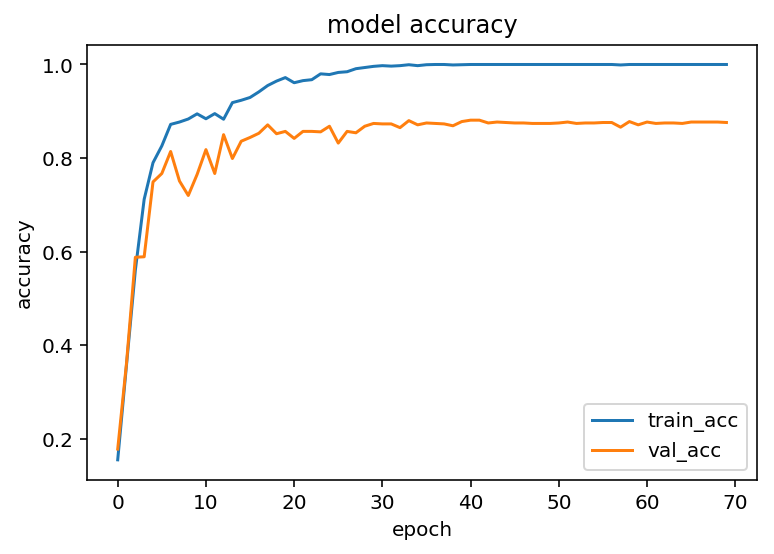

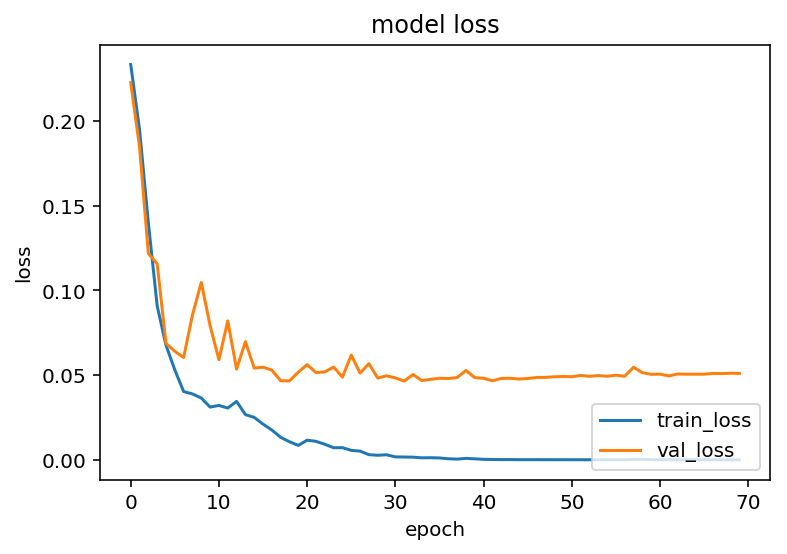

100%|██████████| 57/57 [00:06<00:00,  9.46it/s]
[2017-12-05 02:37:34,352 INFO] Epoch: 0 | TrainAcc: 0.1450 | TrainLoss: 0.2373
[2017-12-05 02:37:34,711 INFO] Epoch: 0 | ValAcc: 0.1440 | ValLoss: 0.2243 

[2017-12-05 02:37:35,984 INFO] Epoch: 1 | TrainAcc: 0.3060 | TrainLoss: 0.2038
[2017-12-05 02:37:36,342 INFO] Epoch: 1 | ValAcc: 0.2800 | ValLoss: 0.1919 

[2017-12-05 02:37:37,586 INFO] Epoch: 2 | TrainAcc: 0.4840 | TrainLoss: 0.1513
[2017-12-05 02:37:37,938 INFO] Epoch: 2 | ValAcc: 0.5000 | ValLoss: 0.1397 

[2017-12-05 02:37:39,194 INFO] Epoch: 3 | TrainAcc: 0.6485 | TrainLoss: 0.1015
[2017-12-05 02:37:39,548 INFO] Epoch: 3 | ValAcc: 0.6680 | ValLoss: 0.1182 

[2017-12-05 02:37:40,855 INFO] Epoch: 4 | TrainAcc: 0.7855 | TrainLoss: 0.0687
[2017-12-05 02:37:41,206 INFO] Epoch: 4 | ValAcc: 0.7590 | ValLoss: 0.0719 

[2017-12-05 02:37:42,500 INFO] Epoch: 5 | TrainAcc: 0.8645 | TrainLoss: 0.0434
[2017-12-05 02:37:42,852 INFO] Epoch: 5 | ValAcc: 0.8020 | ValLoss: 0.0588 

[2017-12-05 02:3

[2017-12-05 02:38:58,577 INFO] Epoch: 51 | ValAcc: 0.8990 | ValLoss: 0.0448 

[2017-12-05 02:38:59,916 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:39:00,385 INFO] Epoch: 52 | ValAcc: 0.8880 | ValLoss: 0.0475 

[2017-12-05 02:39:01,714 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:39:02,073 INFO] Epoch: 53 | ValAcc: 0.8900 | ValLoss: 0.0483 

[2017-12-05 02:39:03,327 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:39:03,682 INFO] Epoch: 54 | ValAcc: 0.8970 | ValLoss: 0.0456 

[2017-12-05 02:39:04,940 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:39:05,300 INFO] Epoch: 55 | ValAcc: 0.8960 | ValLoss: 0.0457 

[2017-12-05 02:39:06,586 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:39:06,950 INFO] Epoch: 56 | ValAcc: 0.8950 | ValLoss: 0.0458 

[2017-12-05 02:39:08,212 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:39:08,567 INFO] Epoch: 57 | ValAcc: 0

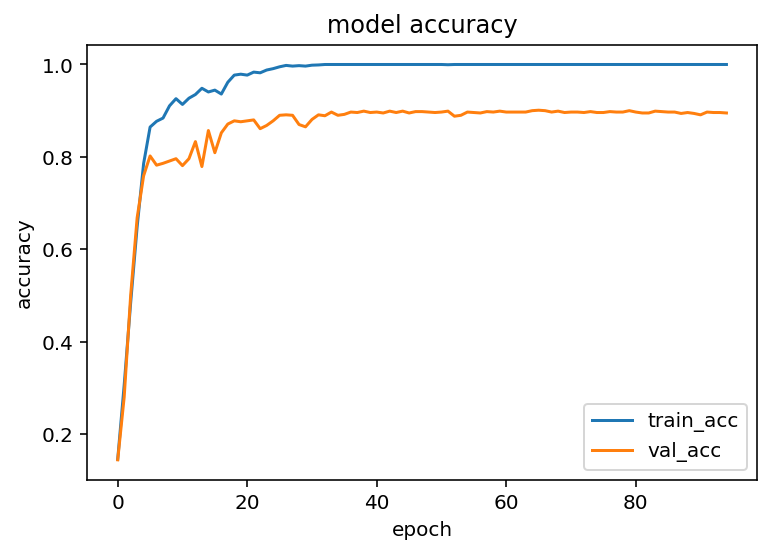

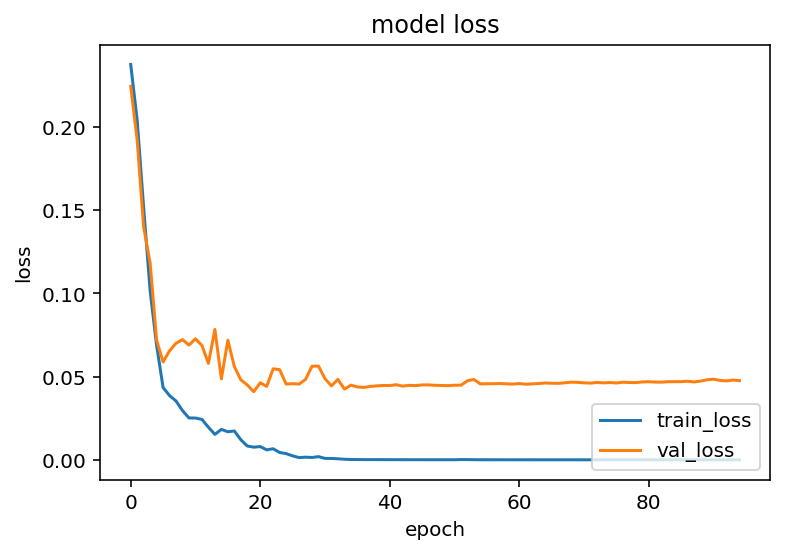

100%|██████████| 57/57 [00:06<00:00,  8.77it/s]
[2017-12-05 02:40:30,071 INFO] Epoch: 0 | TrainAcc: 0.1870 | TrainLoss: 0.2267
[2017-12-05 02:40:30,549 INFO] Epoch: 0 | ValAcc: 0.3780 | ValLoss: 0.2157 

[2017-12-05 02:40:31,883 INFO] Epoch: 1 | TrainAcc: 0.4305 | TrainLoss: 0.1701
[2017-12-05 02:40:32,236 INFO] Epoch: 1 | ValAcc: 0.5660 | ValLoss: 0.1361 

[2017-12-05 02:40:33,538 INFO] Epoch: 2 | TrainAcc: 0.6975 | TrainLoss: 0.1015
[2017-12-05 02:40:33,904 INFO] Epoch: 2 | ValAcc: 0.5810 | ValLoss: 0.1256 

[2017-12-05 02:40:35,276 INFO] Epoch: 3 | TrainAcc: 0.7830 | TrainLoss: 0.0698
[2017-12-05 02:40:35,736 INFO] Epoch: 3 | ValAcc: 0.6710 | ValLoss: 0.0956 

[2017-12-05 02:40:37,038 INFO] Epoch: 4 | TrainAcc: 0.8675 | TrainLoss: 0.0470
[2017-12-05 02:40:37,405 INFO] Epoch: 4 | ValAcc: 0.7850 | ValLoss: 0.0639 

[2017-12-05 02:40:38,682 INFO] Epoch: 5 | TrainAcc: 0.8705 | TrainLoss: 0.0420
[2017-12-05 02:40:39,039 INFO] Epoch: 5 | ValAcc: 0.7470 | ValLoss: 0.0754 

[2017-12-05 02:4

[2017-12-05 02:41:57,177 INFO] Epoch: 51 | ValAcc: 0.9080 | ValLoss: 0.0367 

[2017-12-05 02:41:58,595 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:41:58,956 INFO] Epoch: 52 | ValAcc: 0.9070 | ValLoss: 0.0371 

[2017-12-05 02:42:00,244 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:42:00,599 INFO] Epoch: 53 | ValAcc: 0.9070 | ValLoss: 0.0371 

[2017-12-05 02:42:01,888 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:42:02,242 INFO] Epoch: 54 | ValAcc: 0.9070 | ValLoss: 0.0372 

[2017-12-05 02:42:03,533 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:42:03,897 INFO] Epoch: 55 | ValAcc: 0.9080 | ValLoss: 0.0370 

[2017-12-05 02:42:05,185 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:42:05,546 INFO] Epoch: 56 | ValAcc: 0.9070 | ValLoss: 0.0374 

[2017-12-05 02:42:06,812 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:42:07,176 INFO] Epoch: 57 | ValAcc: 0

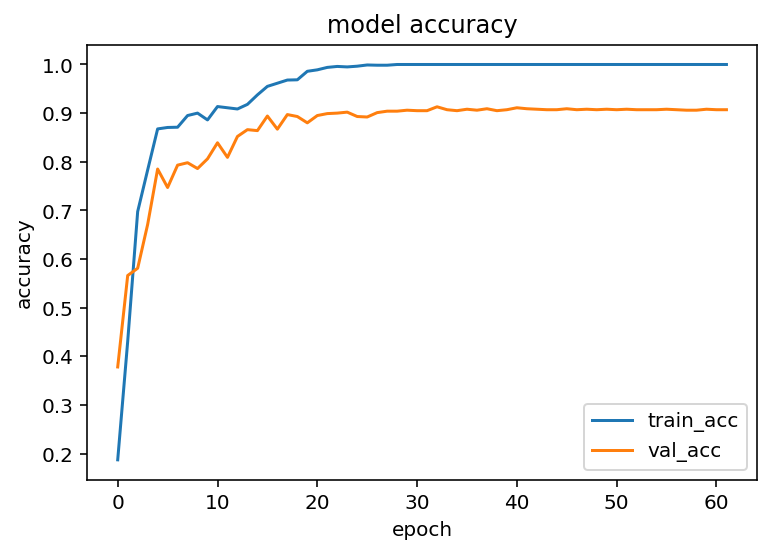

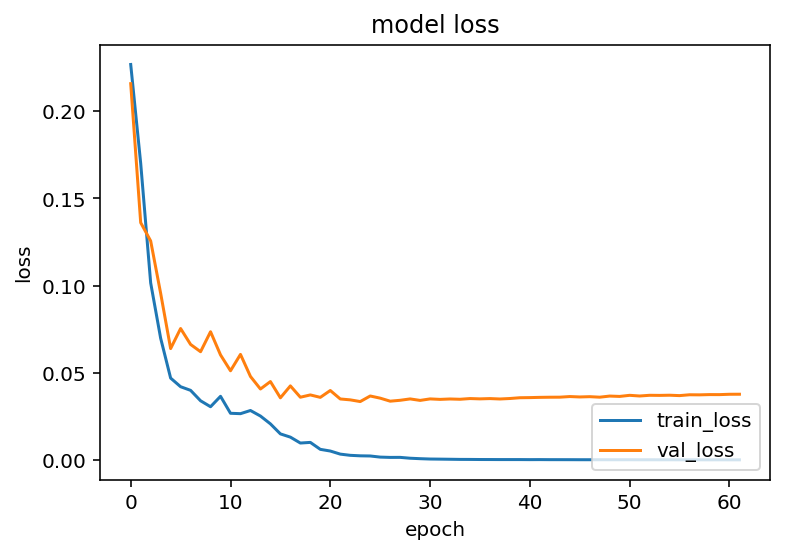

100%|██████████| 57/57 [00:06<00:00,  9.45it/s]
[2017-12-05 02:42:30,136 INFO] Epoch: 0 | TrainAcc: 0.1615 | TrainLoss: 0.2344
[2017-12-05 02:42:30,491 INFO] Epoch: 0 | ValAcc: 0.1360 | ValLoss: 0.2227 

[2017-12-05 02:42:31,767 INFO] Epoch: 1 | TrainAcc: 0.3685 | TrainLoss: 0.1922
[2017-12-05 02:42:32,123 INFO] Epoch: 1 | ValAcc: 0.5290 | ValLoss: 0.1673 

[2017-12-05 02:42:33,395 INFO] Epoch: 2 | TrainAcc: 0.5140 | TrainLoss: 0.1412
[2017-12-05 02:42:33,752 INFO] Epoch: 2 | ValAcc: 0.4960 | ValLoss: 0.1412 

[2017-12-05 02:42:35,045 INFO] Epoch: 3 | TrainAcc: 0.6190 | TrainLoss: 0.1107
[2017-12-05 02:42:35,426 INFO] Epoch: 3 | ValAcc: 0.6030 | ValLoss: 0.1162 

[2017-12-05 02:42:36,718 INFO] Epoch: 4 | TrainAcc: 0.6770 | TrainLoss: 0.0951
[2017-12-05 02:42:37,074 INFO] Epoch: 4 | ValAcc: 0.5920 | ValLoss: 0.1035 

[2017-12-05 02:42:38,353 INFO] Epoch: 5 | TrainAcc: 0.7500 | TrainLoss: 0.0722
[2017-12-05 02:42:38,713 INFO] Epoch: 5 | ValAcc: 0.6480 | ValLoss: 0.1059 

[2017-12-05 02:4

[2017-12-05 02:43:56,570 INFO] Epoch: 51 | ValAcc: 0.9060 | ValLoss: 0.0406 

[2017-12-05 02:43:57,932 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:43:58,310 INFO] Epoch: 52 | ValAcc: 0.9030 | ValLoss: 0.0408 

[2017-12-05 02:43:59,593 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:43:59,945 INFO] Epoch: 53 | ValAcc: 0.9020 | ValLoss: 0.0403 

[2017-12-05 02:44:01,282 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:44:01,632 INFO] Epoch: 54 | ValAcc: 0.9020 | ValLoss: 0.0410 

[2017-12-05 02:44:02,985 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:44:03,359 INFO] Epoch: 55 | ValAcc: 0.9050 | ValLoss: 0.0405 

[2017-12-05 02:44:04,638 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:44:05,009 INFO] Epoch: 56 | ValAcc: 0.9050 | ValLoss: 0.0412 

[2017-12-05 02:44:06,301 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:44:06,684 INFO] Epoch: 57 | ValAcc: 0

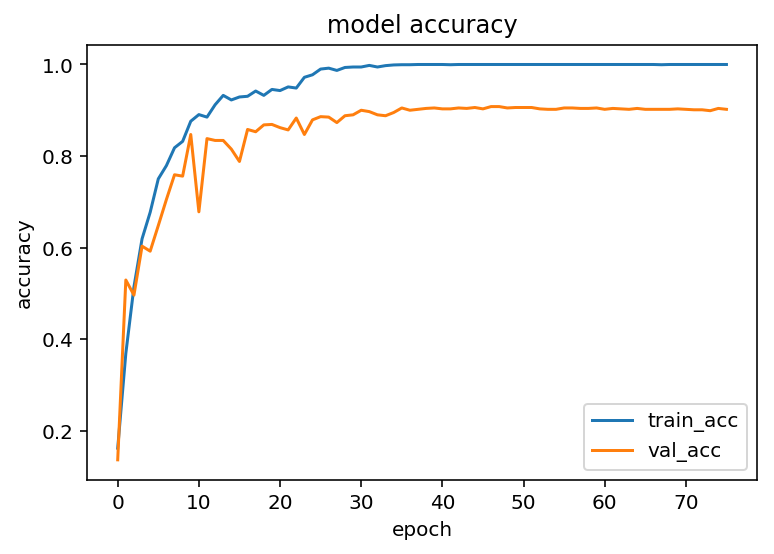

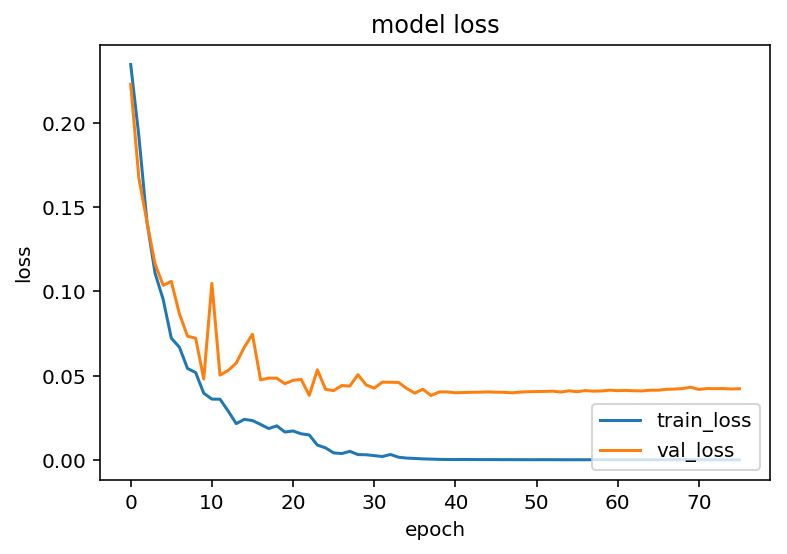

100%|██████████| 57/57 [00:06<00:00,  9.26it/s]
[2017-12-05 02:44:52,909 INFO] Epoch: 0 | TrainAcc: 0.1765 | TrainLoss: 0.2301
[2017-12-05 02:44:53,332 INFO] Epoch: 0 | ValAcc: 0.2820 | ValLoss: 0.2147 

[2017-12-05 02:44:54,592 INFO] Epoch: 1 | TrainAcc: 0.3990 | TrainLoss: 0.1835
[2017-12-05 02:44:54,951 INFO] Epoch: 1 | ValAcc: 0.4830 | ValLoss: 0.1617 

[2017-12-05 02:44:56,197 INFO] Epoch: 2 | TrainAcc: 0.5890 | TrainLoss: 0.1253
[2017-12-05 02:44:56,561 INFO] Epoch: 2 | ValAcc: 0.5530 | ValLoss: 0.1451 

[2017-12-05 02:44:57,828 INFO] Epoch: 3 | TrainAcc: 0.7515 | TrainLoss: 0.0777
[2017-12-05 02:44:58,181 INFO] Epoch: 3 | ValAcc: 0.7210 | ValLoss: 0.0835 

[2017-12-05 02:44:59,459 INFO] Epoch: 4 | TrainAcc: 0.8440 | TrainLoss: 0.0518
[2017-12-05 02:44:59,825 INFO] Epoch: 4 | ValAcc: 0.7740 | ValLoss: 0.0707 

[2017-12-05 02:45:01,086 INFO] Epoch: 5 | TrainAcc: 0.8425 | TrainLoss: 0.0493
[2017-12-05 02:45:01,431 INFO] Epoch: 5 | ValAcc: 0.7330 | ValLoss: 0.0861 

[2017-12-05 02:4

[2017-12-05 02:46:19,911 INFO] Epoch: 51 | ValAcc: 0.8890 | ValLoss: 0.0539 

[2017-12-05 02:46:21,188 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-05 02:46:21,545 INFO] Epoch: 52 | ValAcc: 0.8900 | ValLoss: 0.0487 

[2017-12-05 02:46:22,859 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:46:23,215 INFO] Epoch: 53 | ValAcc: 0.8900 | ValLoss: 0.0509 

[2017-12-05 02:46:24,501 INFO] Epoch: 54 | TrainAcc: 0.9995 | TrainLoss: 0.0003
[2017-12-05 02:46:24,865 INFO] Epoch: 54 | ValAcc: 0.8900 | ValLoss: 0.0514 

[2017-12-05 02:46:26,131 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:46:26,498 INFO] Epoch: 55 | ValAcc: 0.8930 | ValLoss: 0.0515 

[2017-12-05 02:46:27,765 INFO] Epoch: 56 | TrainAcc: 0.9995 | TrainLoss: 0.0003
[2017-12-05 02:46:28,122 INFO] Epoch: 56 | ValAcc: 0.8910 | ValLoss: 0.0509 

[2017-12-05 02:46:29,411 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:46:29,777 INFO] Epoch: 57 | ValAcc: 0

[2017-12-05 02:47:47,006 INFO] Epoch: 103 | ValAcc: 0.8900 | ValLoss: 0.0573 

[2017-12-05 02:47:48,317 INFO] Epoch: 104 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:47:48,681 INFO] Epoch: 104 | ValAcc: 0.8940 | ValLoss: 0.0542 

[2017-12-05 02:47:49,968 INFO] Epoch: 105 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:47:50,318 INFO] Epoch: 105 | ValAcc: 0.8940 | ValLoss: 0.0542 

[2017-12-05 02:47:51,620 INFO] Epoch: 106 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:47:51,969 INFO] Epoch: 106 | ValAcc: 0.8940 | ValLoss: 0.0547 

[2017-12-05 02:47:53,268 INFO] Epoch: 107 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:47:53,634 INFO] Epoch: 107 | ValAcc: 0.8950 | ValLoss: 0.0547 

[2017-12-05 02:47:54,946 INFO] Epoch: 108 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:47:55,300 INFO] Epoch: 108 | ValAcc: 0.8960 | ValLoss: 0.0548 

[2017-12-05 02:47:56,624 INFO] Epoch: 109 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:47:57,004 INFO] Epoch: 10

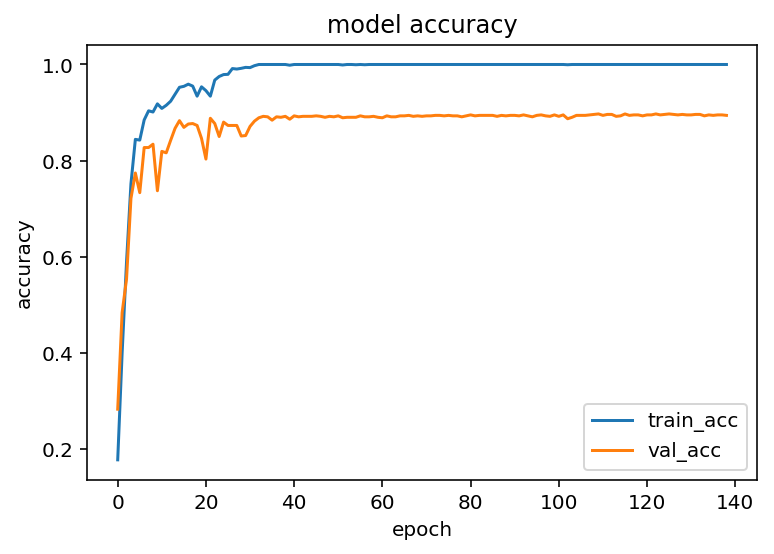

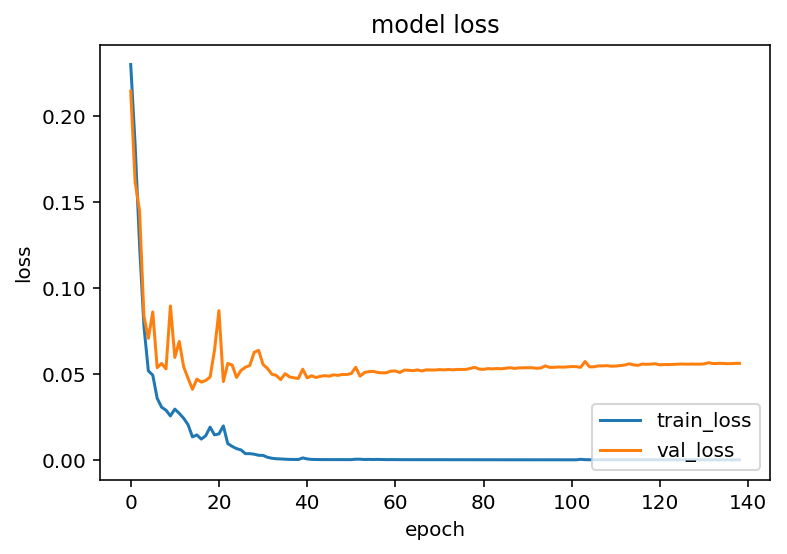

100%|██████████| 57/57 [00:06<00:00,  8.89it/s]
[2017-12-05 02:49:04,234 INFO] Epoch: 0 | TrainAcc: 0.1615 | TrainLoss: 0.2316
[2017-12-05 02:49:04,593 INFO] Epoch: 0 | ValAcc: 0.2690 | ValLoss: 0.2212 

[2017-12-05 02:49:05,843 INFO] Epoch: 1 | TrainAcc: 0.4185 | TrainLoss: 0.1903
[2017-12-05 02:49:06,201 INFO] Epoch: 1 | ValAcc: 0.4140 | ValLoss: 0.1714 

[2017-12-05 02:49:07,458 INFO] Epoch: 2 | TrainAcc: 0.5450 | TrainLoss: 0.1349
[2017-12-05 02:49:07,805 INFO] Epoch: 2 | ValAcc: 0.4270 | ValLoss: 0.1569 

[2017-12-05 02:49:09,152 INFO] Epoch: 3 | TrainAcc: 0.6380 | TrainLoss: 0.1084
[2017-12-05 02:49:09,528 INFO] Epoch: 3 | ValAcc: 0.6370 | ValLoss: 0.1044 

[2017-12-05 02:49:10,863 INFO] Epoch: 4 | TrainAcc: 0.7790 | TrainLoss: 0.0747
[2017-12-05 02:49:11,233 INFO] Epoch: 4 | ValAcc: 0.7210 | ValLoss: 0.0872 

[2017-12-05 02:49:12,525 INFO] Epoch: 5 | TrainAcc: 0.8380 | TrainLoss: 0.0561
[2017-12-05 02:49:12,895 INFO] Epoch: 5 | ValAcc: 0.6590 | ValLoss: 0.1049 

[2017-12-05 02:4

[2017-12-05 02:50:29,093 INFO] Epoch: 51 | ValAcc: 0.8610 | ValLoss: 0.0598 

[2017-12-05 02:50:30,394 INFO] Epoch: 52 | TrainAcc: 0.9985 | TrainLoss: 0.0007
[2017-12-05 02:50:30,763 INFO] Epoch: 52 | ValAcc: 0.8580 | ValLoss: 0.0626 

[2017-12-05 02:50:32,037 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0006
[2017-12-05 02:50:32,393 INFO] Epoch: 53 | ValAcc: 0.8540 | ValLoss: 0.0624 

[2017-12-05 02:50:33,664 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-05 02:50:34,019 INFO] Epoch: 54 | ValAcc: 0.8580 | ValLoss: 0.0591 

[2017-12-05 02:50:35,280 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-05 02:50:35,643 INFO] Epoch: 55 | ValAcc: 0.8640 | ValLoss: 0.0593 

[2017-12-05 02:50:35,671 INFO] Accuracy dose not improve for a long epochs
[2017-12-05 02:50:35,673 INFO] Train done.
[2017-12-05 02:50:35,674 INFO] Elapsed Time: 92.65180516242981


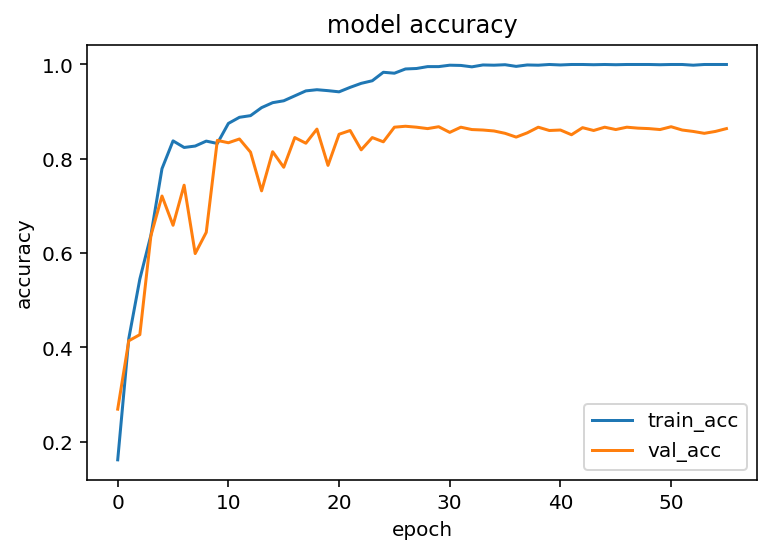

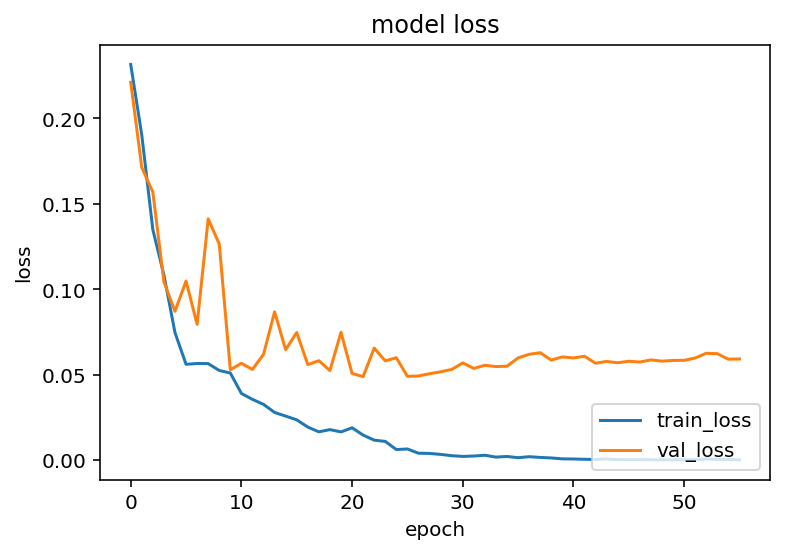

100%|██████████| 57/57 [00:06<00:00,  9.37it/s]
[2017-12-05 02:50:51,875 INFO] Epoch: 0 | TrainAcc: 0.1465 | TrainLoss: 0.2527
[2017-12-05 02:50:52,238 INFO] Epoch: 0 | ValAcc: 0.2080 | ValLoss: 0.2249 

[2017-12-05 02:50:53,526 INFO] Epoch: 1 | TrainAcc: 0.3060 | TrainLoss: 0.2103
[2017-12-05 02:50:53,876 INFO] Epoch: 1 | ValAcc: 0.3480 | ValLoss: 0.2018 

[2017-12-05 02:50:55,145 INFO] Epoch: 2 | TrainAcc: 0.4610 | TrainLoss: 0.1634
[2017-12-05 02:50:55,507 INFO] Epoch: 2 | ValAcc: 0.5540 | ValLoss: 0.1553 

[2017-12-05 02:50:56,805 INFO] Epoch: 3 | TrainAcc: 0.6265 | TrainLoss: 0.1139
[2017-12-05 02:50:57,156 INFO] Epoch: 3 | ValAcc: 0.4190 | ValLoss: 0.2137 

[2017-12-05 02:50:58,437 INFO] Epoch: 4 | TrainAcc: 0.6830 | TrainLoss: 0.0920
[2017-12-05 02:50:58,792 INFO] Epoch: 4 | ValAcc: 0.6030 | ValLoss: 0.1188 

[2017-12-05 02:51:00,076 INFO] Epoch: 5 | TrainAcc: 0.7600 | TrainLoss: 0.0711
[2017-12-05 02:51:00,436 INFO] Epoch: 5 | ValAcc: 0.6190 | ValLoss: 0.1248 

[2017-12-05 02:5

[2017-12-05 02:52:20,574 INFO] Epoch: 51 | ValAcc: 0.8690 | ValLoss: 0.0576 

[2017-12-05 02:52:21,969 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:52:22,317 INFO] Epoch: 52 | ValAcc: 0.8700 | ValLoss: 0.0584 

[2017-12-05 02:52:23,647 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:52:24,084 INFO] Epoch: 53 | ValAcc: 0.8670 | ValLoss: 0.0591 

[2017-12-05 02:52:25,350 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:52:25,695 INFO] Epoch: 54 | ValAcc: 0.8700 | ValLoss: 0.0581 

[2017-12-05 02:52:27,005 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:52:27,417 INFO] Epoch: 55 | ValAcc: 0.8680 | ValLoss: 0.0587 

[2017-12-05 02:52:28,735 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:52:29,086 INFO] Epoch: 56 | ValAcc: 0.8670 | ValLoss: 0.0586 

[2017-12-05 02:52:30,337 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:52:30,690 INFO] Epoch: 57 | ValAcc: 0

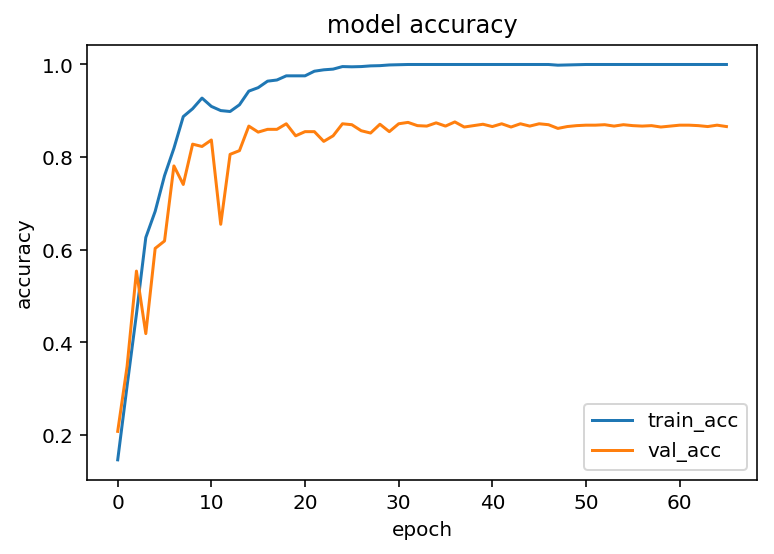

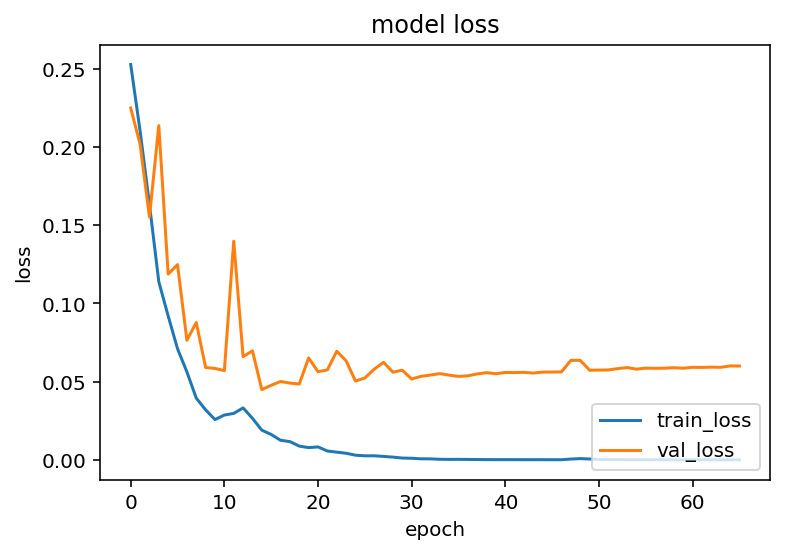

100%|██████████| 57/57 [00:07<00:00,  7.87it/s]
[2017-12-05 02:53:01,332 INFO] Epoch: 0 | TrainAcc: 0.2460 | TrainLoss: 0.2163
[2017-12-05 02:53:01,731 INFO] Epoch: 0 | ValAcc: 0.3130 | ValLoss: 0.2095 

[2017-12-05 02:53:03,384 INFO] Epoch: 1 | TrainAcc: 0.4330 | TrainLoss: 0.1621
[2017-12-05 02:53:03,857 INFO] Epoch: 1 | ValAcc: 0.4710 | ValLoss: 0.1439 

[2017-12-05 02:53:05,426 INFO] Epoch: 2 | TrainAcc: 0.6705 | TrainLoss: 0.1010
[2017-12-05 02:53:05,896 INFO] Epoch: 2 | ValAcc: 0.5830 | ValLoss: 0.1167 

[2017-12-05 02:53:07,302 INFO] Epoch: 3 | TrainAcc: 0.8120 | TrainLoss: 0.0612
[2017-12-05 02:53:07,659 INFO] Epoch: 3 | ValAcc: 0.6780 | ValLoss: 0.0970 

[2017-12-05 02:53:08,954 INFO] Epoch: 4 | TrainAcc: 0.8305 | TrainLoss: 0.0544
[2017-12-05 02:53:09,307 INFO] Epoch: 4 | ValAcc: 0.7740 | ValLoss: 0.0696 

[2017-12-05 02:53:10,603 INFO] Epoch: 5 | TrainAcc: 0.8600 | TrainLoss: 0.0455
[2017-12-05 02:53:10,951 INFO] Epoch: 5 | ValAcc: 0.8120 | ValLoss: 0.0597 

[2017-12-05 02:5

[2017-12-05 02:54:29,518 INFO] Epoch: 51 | ValAcc: 0.8980 | ValLoss: 0.0391 

[2017-12-05 02:54:30,967 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:54:31,421 INFO] Epoch: 52 | ValAcc: 0.8990 | ValLoss: 0.0393 

[2017-12-05 02:54:32,816 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:54:33,171 INFO] Epoch: 53 | ValAcc: 0.8970 | ValLoss: 0.0388 

[2017-12-05 02:54:34,453 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:54:34,805 INFO] Epoch: 54 | ValAcc: 0.8980 | ValLoss: 0.0396 

[2017-12-05 02:54:36,090 INFO] Epoch: 55 | TrainAcc: 0.9995 | TrainLoss: 0.0005
[2017-12-05 02:54:36,448 INFO] Epoch: 55 | ValAcc: 0.8960 | ValLoss: 0.0410 

[2017-12-05 02:54:37,706 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:54:38,055 INFO] Epoch: 56 | ValAcc: 0.8910 | ValLoss: 0.0397 

[2017-12-05 02:54:39,353 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:54:39,700 INFO] Epoch: 57 | ValAcc: 0

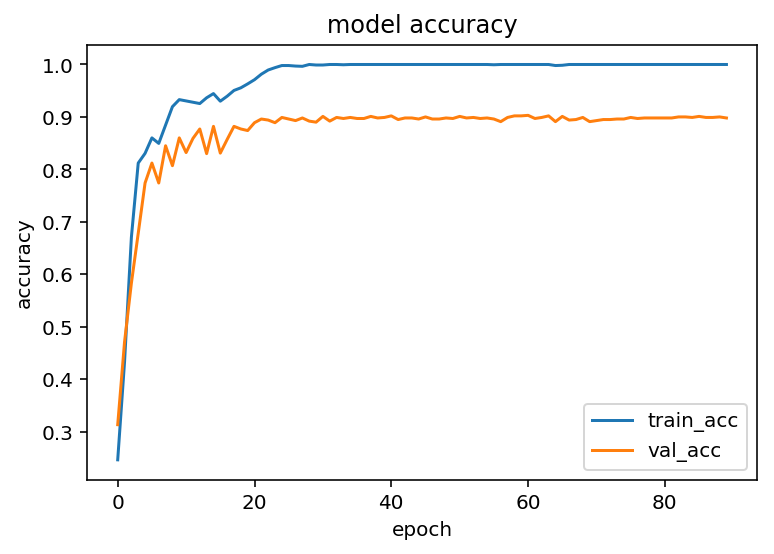

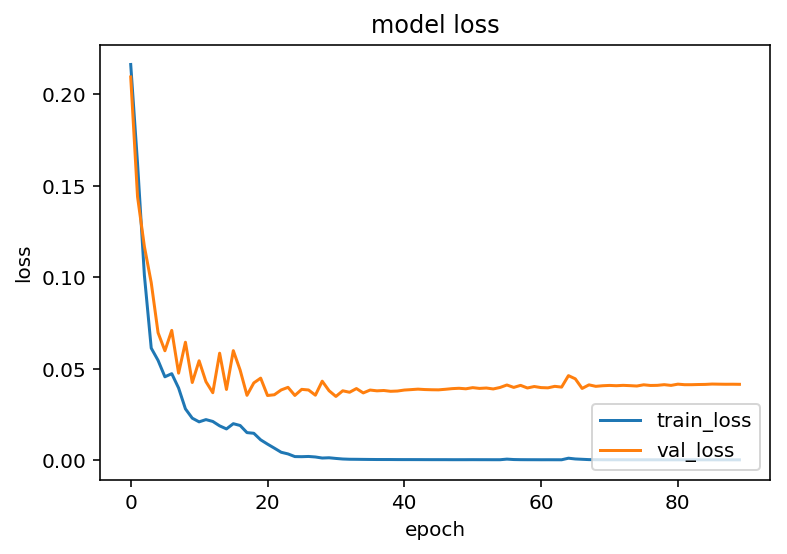

100%|██████████| 57/57 [00:06<00:00,  8.84it/s]
[2017-12-05 02:55:49,392 INFO] Epoch: 0 | TrainAcc: 0.1740 | TrainLoss: 0.2254
[2017-12-05 02:55:49,755 INFO] Epoch: 0 | ValAcc: 0.2400 | ValLoss: 0.2226 

[2017-12-05 02:55:51,052 INFO] Epoch: 1 | TrainAcc: 0.4115 | TrainLoss: 0.1824
[2017-12-05 02:55:51,410 INFO] Epoch: 1 | ValAcc: 0.3570 | ValLoss: 0.1844 

[2017-12-05 02:55:52,745 INFO] Epoch: 2 | TrainAcc: 0.4915 | TrainLoss: 0.1473
[2017-12-05 02:55:53,206 INFO] Epoch: 2 | ValAcc: 0.5940 | ValLoss: 0.1254 

[2017-12-05 02:55:54,739 INFO] Epoch: 3 | TrainAcc: 0.6425 | TrainLoss: 0.1064
[2017-12-05 02:55:55,111 INFO] Epoch: 3 | ValAcc: 0.6380 | ValLoss: 0.1098 

[2017-12-05 02:55:56,657 INFO] Epoch: 4 | TrainAcc: 0.7250 | TrainLoss: 0.0836
[2017-12-05 02:55:57,109 INFO] Epoch: 4 | ValAcc: 0.6730 | ValLoss: 0.1034 

[2017-12-05 02:55:58,557 INFO] Epoch: 5 | TrainAcc: 0.7825 | TrainLoss: 0.0665
[2017-12-05 02:55:58,916 INFO] Epoch: 5 | ValAcc: 0.7200 | ValLoss: 0.0857 

[2017-12-05 02:5

[2017-12-05 02:57:16,431 INFO] Epoch: 51 | ValAcc: 0.8870 | ValLoss: 0.0489 

[2017-12-05 02:57:17,731 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:57:18,079 INFO] Epoch: 52 | ValAcc: 0.8860 | ValLoss: 0.0493 

[2017-12-05 02:57:19,364 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:57:19,732 INFO] Epoch: 53 | ValAcc: 0.8880 | ValLoss: 0.0495 

[2017-12-05 02:57:21,055 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:57:21,402 INFO] Epoch: 54 | ValAcc: 0.8860 | ValLoss: 0.0495 

[2017-12-05 02:57:22,689 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:57:23,043 INFO] Epoch: 55 | ValAcc: 0.8880 | ValLoss: 0.0492 

[2017-12-05 02:57:24,348 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:57:24,700 INFO] Epoch: 56 | ValAcc: 0.8900 | ValLoss: 0.0495 

[2017-12-05 02:57:26,034 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:57:26,501 INFO] Epoch: 57 | ValAcc: 0

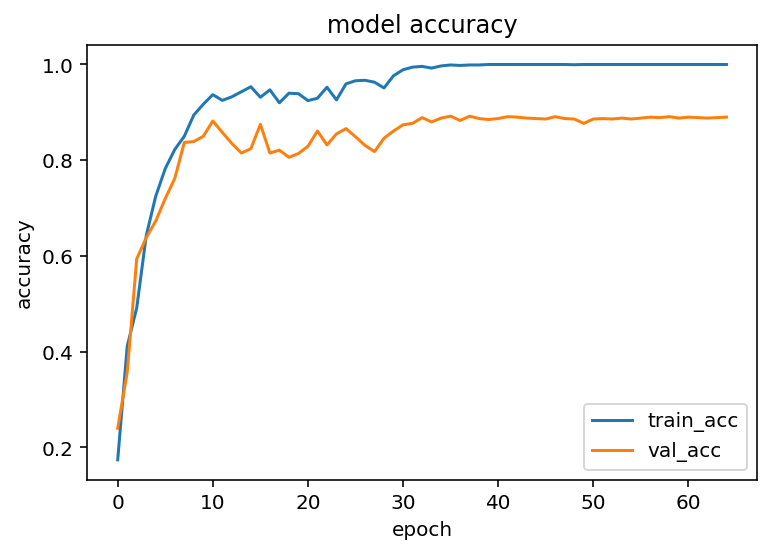

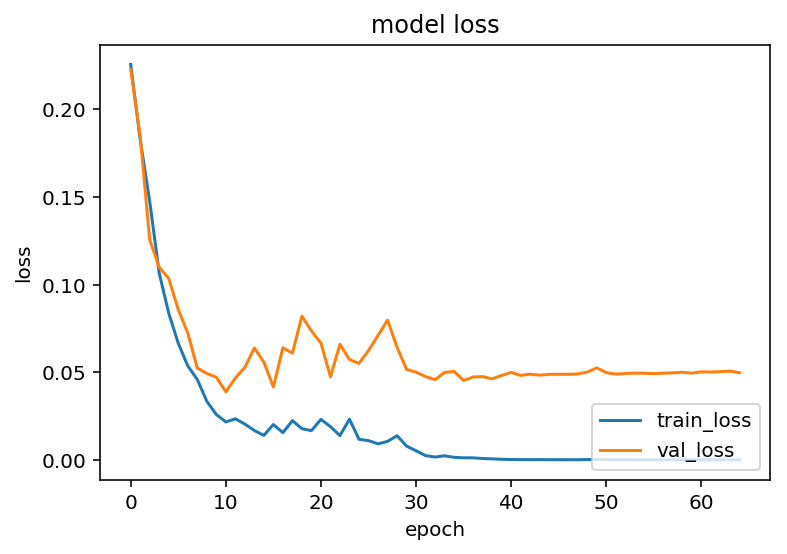

100%|██████████| 57/57 [00:08<00:00,  7.02it/s]
[2017-12-05 02:57:57,646 INFO] Epoch: 0 | TrainAcc: 0.1685 | TrainLoss: 0.2355
[2017-12-05 02:57:58,037 INFO] Epoch: 0 | ValAcc: 0.2100 | ValLoss: 0.2215 

[2017-12-05 02:57:59,299 INFO] Epoch: 1 | TrainAcc: 0.3545 | TrainLoss: 0.1921
[2017-12-05 02:57:59,673 INFO] Epoch: 1 | ValAcc: 0.4000 | ValLoss: 0.1748 

[2017-12-05 02:58:01,015 INFO] Epoch: 2 | TrainAcc: 0.4955 | TrainLoss: 0.1426
[2017-12-05 02:58:01,369 INFO] Epoch: 2 | ValAcc: 0.5270 | ValLoss: 0.1400 

[2017-12-05 02:58:02,691 INFO] Epoch: 3 | TrainAcc: 0.6210 | TrainLoss: 0.1040
[2017-12-05 02:58:03,047 INFO] Epoch: 3 | ValAcc: 0.5410 | ValLoss: 0.1449 

[2017-12-05 02:58:04,369 INFO] Epoch: 4 | TrainAcc: 0.7445 | TrainLoss: 0.0751
[2017-12-05 02:58:04,734 INFO] Epoch: 4 | ValAcc: 0.7260 | ValLoss: 0.0837 

[2017-12-05 02:58:06,297 INFO] Epoch: 5 | TrainAcc: 0.7970 | TrainLoss: 0.0622
[2017-12-05 02:58:06,799 INFO] Epoch: 5 | ValAcc: 0.6980 | ValLoss: 0.0969 

[2017-12-05 02:5

[2017-12-05 02:59:26,206 INFO] Epoch: 51 | ValAcc: 0.8810 | ValLoss: 0.0535 

[2017-12-05 02:59:27,494 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 02:59:27,876 INFO] Epoch: 52 | ValAcc: 0.8820 | ValLoss: 0.0536 

[2017-12-05 02:59:29,189 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:59:29,546 INFO] Epoch: 53 | ValAcc: 0.8820 | ValLoss: 0.0540 

[2017-12-05 02:59:30,827 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:59:31,184 INFO] Epoch: 54 | ValAcc: 0.8810 | ValLoss: 0.0535 

[2017-12-05 02:59:32,468 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:59:32,822 INFO] Epoch: 55 | ValAcc: 0.8820 | ValLoss: 0.0538 

[2017-12-05 02:59:34,134 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 02:59:34,485 INFO] Epoch: 56 | ValAcc: 0.8810 | ValLoss: 0.0542 

[2017-12-05 02:59:34,513 INFO] Accuracy dose not improve for a long epochs
[2017-12-05 02:59:34,515 INFO] Train done.
[2017-12-05 02

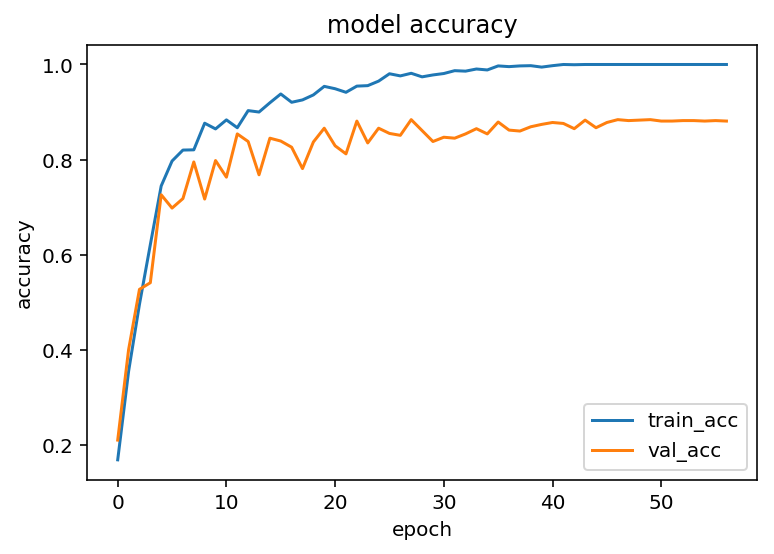

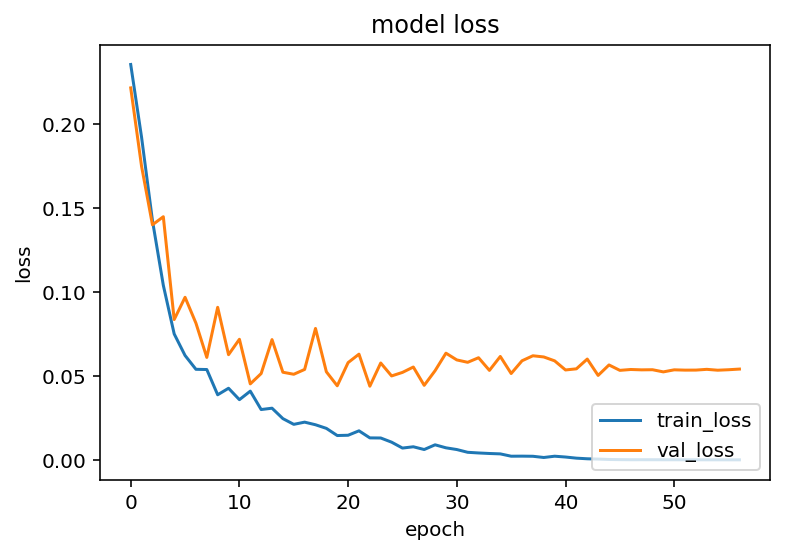

100%|██████████| 57/57 [00:06<00:00,  9.39it/s]
[2017-12-05 02:59:50,522 INFO] Epoch: 0 | TrainAcc: 0.1630 | TrainLoss: 0.2318
[2017-12-05 02:59:50,880 INFO] Epoch: 0 | ValAcc: 0.2410 | ValLoss: 0.2188 

[2017-12-05 02:59:52,176 INFO] Epoch: 1 | TrainAcc: 0.3560 | TrainLoss: 0.1885
[2017-12-05 02:59:52,538 INFO] Epoch: 1 | ValAcc: 0.2090 | ValLoss: 0.1984 

[2017-12-05 02:59:53,819 INFO] Epoch: 2 | TrainAcc: 0.5195 | TrainLoss: 0.1407
[2017-12-05 02:59:54,179 INFO] Epoch: 2 | ValAcc: 0.5290 | ValLoss: 0.1441 

[2017-12-05 02:59:55,453 INFO] Epoch: 3 | TrainAcc: 0.6850 | TrainLoss: 0.0990
[2017-12-05 02:59:55,797 INFO] Epoch: 3 | ValAcc: 0.6790 | ValLoss: 0.0971 

[2017-12-05 02:59:57,074 INFO] Epoch: 4 | TrainAcc: 0.7645 | TrainLoss: 0.0728
[2017-12-05 02:59:57,444 INFO] Epoch: 4 | ValAcc: 0.5280 | ValLoss: 0.1480 

[2017-12-05 02:59:58,760 INFO] Epoch: 5 | TrainAcc: 0.7875 | TrainLoss: 0.0666
[2017-12-05 02:59:59,131 INFO] Epoch: 5 | ValAcc: 0.7010 | ValLoss: 0.0940 

[2017-12-05 03:0

[2017-12-05 03:01:15,009 INFO] Epoch: 51 | ValAcc: 0.8930 | ValLoss: 0.0456 

[2017-12-05 03:01:16,286 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:01:16,640 INFO] Epoch: 52 | ValAcc: 0.8960 | ValLoss: 0.0455 

[2017-12-05 03:01:17,905 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:01:18,254 INFO] Epoch: 53 | ValAcc: 0.8940 | ValLoss: 0.0456 

[2017-12-05 03:01:19,548 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:01:19,906 INFO] Epoch: 54 | ValAcc: 0.8920 | ValLoss: 0.0462 

[2017-12-05 03:01:21,191 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:01:21,549 INFO] Epoch: 55 | ValAcc: 0.8930 | ValLoss: 0.0468 

[2017-12-05 03:01:22,854 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:01:23,199 INFO] Epoch: 56 | ValAcc: 0.9000 | ValLoss: 0.0460 

[2017-12-05 03:01:24,494 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:01:24,840 INFO] Epoch: 57 | ValAcc: 0

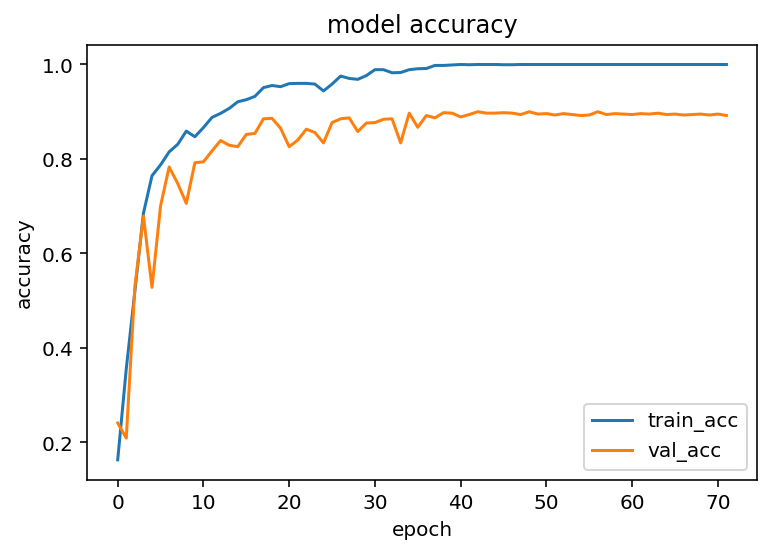

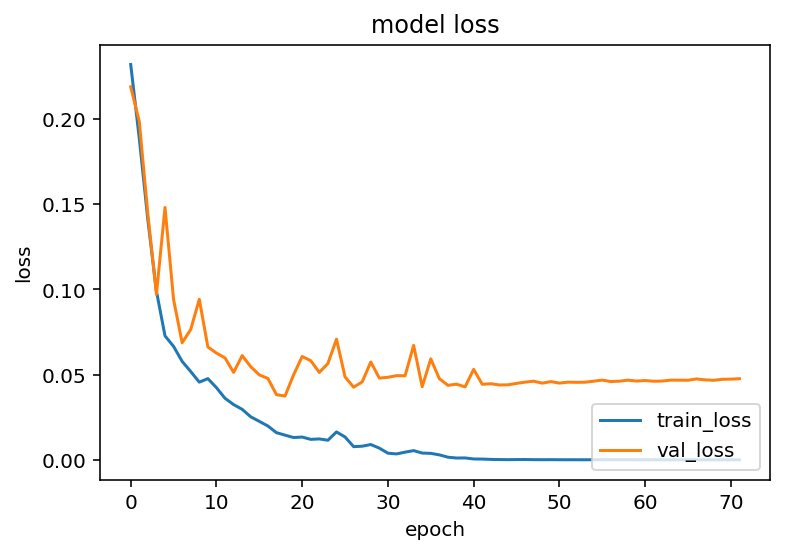

100%|██████████| 57/57 [00:06<00:00,  9.24it/s]
[2017-12-05 03:02:04,140 INFO] Epoch: 0 | TrainAcc: 0.1645 | TrainLoss: 0.2389
[2017-12-05 03:02:04,495 INFO] Epoch: 0 | ValAcc: 0.1270 | ValLoss: 0.2220 

[2017-12-05 03:02:05,768 INFO] Epoch: 1 | TrainAcc: 0.3630 | TrainLoss: 0.1968
[2017-12-05 03:02:06,112 INFO] Epoch: 1 | ValAcc: 0.4060 | ValLoss: 0.1796 

[2017-12-05 03:02:07,396 INFO] Epoch: 2 | TrainAcc: 0.5320 | TrainLoss: 0.1402
[2017-12-05 03:02:07,749 INFO] Epoch: 2 | ValAcc: 0.5390 | ValLoss: 0.1334 

[2017-12-05 03:02:09,040 INFO] Epoch: 3 | TrainAcc: 0.6330 | TrainLoss: 0.1042
[2017-12-05 03:02:09,393 INFO] Epoch: 3 | ValAcc: 0.6040 | ValLoss: 0.1219 

[2017-12-05 03:02:10,743 INFO] Epoch: 4 | TrainAcc: 0.7635 | TrainLoss: 0.0709
[2017-12-05 03:02:11,105 INFO] Epoch: 4 | ValAcc: 0.7860 | ValLoss: 0.0601 

[2017-12-05 03:02:12,396 INFO] Epoch: 5 | TrainAcc: 0.8465 | TrainLoss: 0.0485
[2017-12-05 03:02:12,768 INFO] Epoch: 5 | ValAcc: 0.7690 | ValLoss: 0.0667 

[2017-12-05 03:0

[2017-12-05 03:03:32,228 INFO] Epoch: 51 | ValAcc: 0.8900 | ValLoss: 0.0453 

[2017-12-05 03:03:33,479 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:03:33,820 INFO] Epoch: 52 | ValAcc: 0.8850 | ValLoss: 0.0451 

[2017-12-05 03:03:35,076 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:03:35,426 INFO] Epoch: 53 | ValAcc: 0.8880 | ValLoss: 0.0452 

[2017-12-05 03:03:36,712 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:03:37,077 INFO] Epoch: 54 | ValAcc: 0.8870 | ValLoss: 0.0454 

[2017-12-05 03:03:38,329 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:03:38,683 INFO] Epoch: 55 | ValAcc: 0.8860 | ValLoss: 0.0451 

[2017-12-05 03:03:39,939 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:03:40,298 INFO] Epoch: 56 | ValAcc: 0.8860 | ValLoss: 0.0452 

[2017-12-05 03:03:41,583 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:03:41,934 INFO] Epoch: 57 | ValAcc: 0

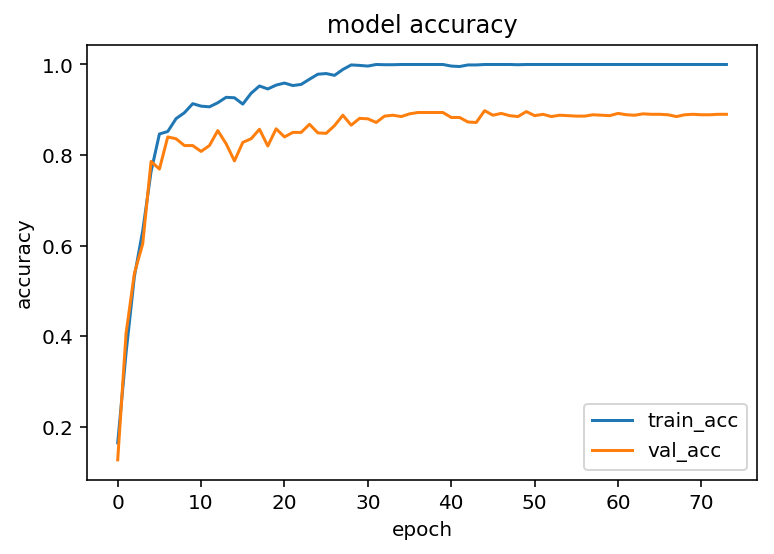

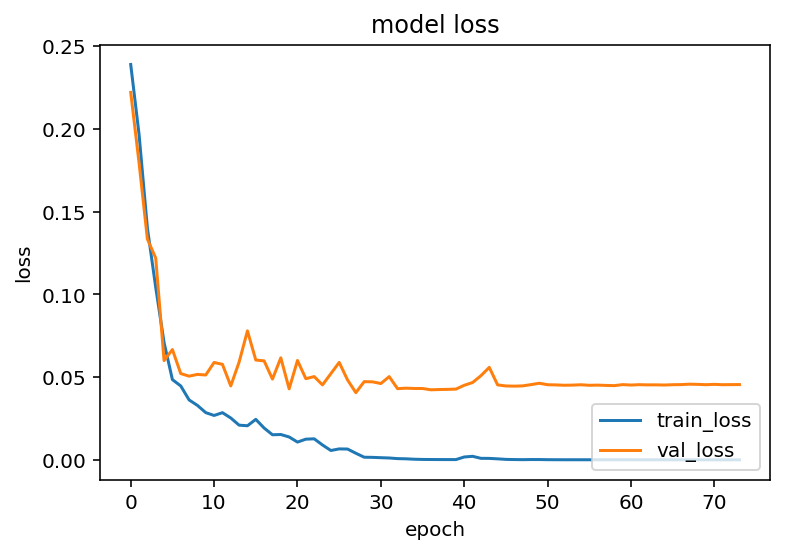

100%|██████████| 57/57 [00:06<00:00,  8.84it/s]
[2017-12-05 03:04:25,925 INFO] Epoch: 0 | TrainAcc: 0.1820 | TrainLoss: 0.2254
[2017-12-05 03:04:26,332 INFO] Epoch: 0 | ValAcc: 0.2600 | ValLoss: 0.2162 

[2017-12-05 03:04:27,777 INFO] Epoch: 1 | TrainAcc: 0.4835 | TrainLoss: 0.1628
[2017-12-05 03:04:28,125 INFO] Epoch: 1 | ValAcc: 0.2190 | ValLoss: 0.2007 

[2017-12-05 03:04:29,403 INFO] Epoch: 2 | TrainAcc: 0.6895 | TrainLoss: 0.0955
[2017-12-05 03:04:29,765 INFO] Epoch: 2 | ValAcc: 0.7300 | ValLoss: 0.0830 

[2017-12-05 03:04:31,318 INFO] Epoch: 3 | TrainAcc: 0.7810 | TrainLoss: 0.0661
[2017-12-05 03:04:31,760 INFO] Epoch: 3 | ValAcc: 0.6300 | ValLoss: 0.1034 

[2017-12-05 03:04:33,516 INFO] Epoch: 4 | TrainAcc: 0.8370 | TrainLoss: 0.0512
[2017-12-05 03:04:33,940 INFO] Epoch: 4 | ValAcc: 0.7730 | ValLoss: 0.0664 

[2017-12-05 03:04:35,317 INFO] Epoch: 5 | TrainAcc: 0.8630 | TrainLoss: 0.0429
[2017-12-05 03:04:35,711 INFO] Epoch: 5 | ValAcc: 0.8340 | ValLoss: 0.0533 

[2017-12-05 03:0

[2017-12-05 03:05:53,263 INFO] Epoch: 51 | ValAcc: 0.8860 | ValLoss: 0.0461 

[2017-12-05 03:05:54,519 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:05:54,869 INFO] Epoch: 52 | ValAcc: 0.8890 | ValLoss: 0.0448 

[2017-12-05 03:05:56,139 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:05:56,496 INFO] Epoch: 53 | ValAcc: 0.8920 | ValLoss: 0.0451 

[2017-12-05 03:05:57,752 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:05:58,099 INFO] Epoch: 54 | ValAcc: 0.8880 | ValLoss: 0.0454 

[2017-12-05 03:05:59,352 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:05:59,703 INFO] Epoch: 55 | ValAcc: 0.8860 | ValLoss: 0.0455 

[2017-12-05 03:06:01,079 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:06:01,437 INFO] Epoch: 56 | ValAcc: 0.8900 | ValLoss: 0.0453 

[2017-12-05 03:06:02,701 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:06:03,041 INFO] Epoch: 57 | ValAcc: 0

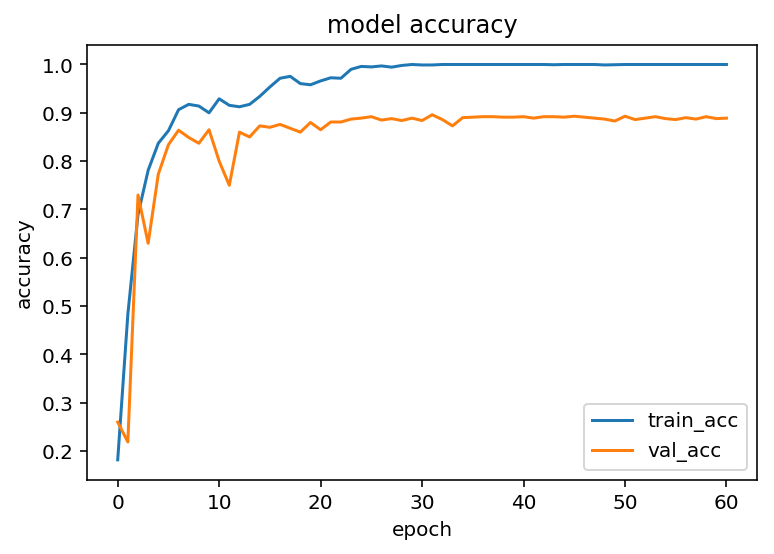

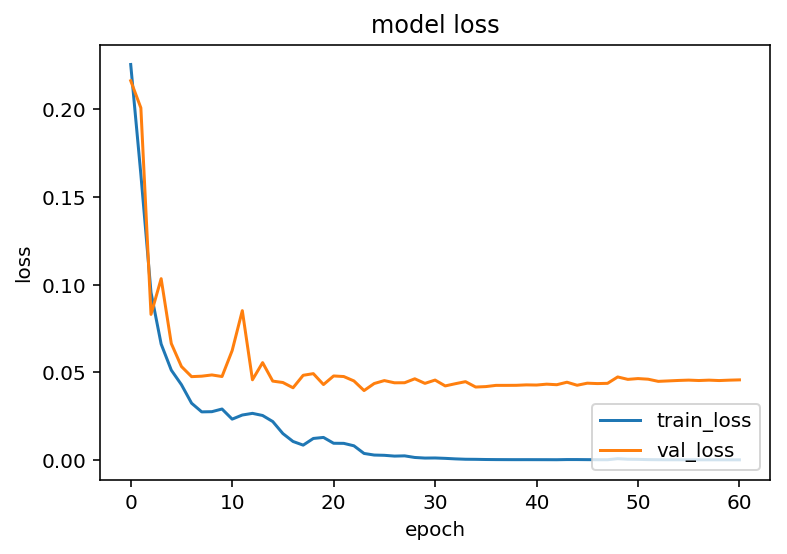

100%|██████████| 57/57 [00:06<00:00,  9.12it/s]
[2017-12-05 03:06:24,114 INFO] Epoch: 0 | TrainAcc: 0.1695 | TrainLoss: 0.2283
[2017-12-05 03:06:24,465 INFO] Epoch: 0 | ValAcc: 0.2290 | ValLoss: 0.2193 

[2017-12-05 03:06:25,809 INFO] Epoch: 1 | TrainAcc: 0.3770 | TrainLoss: 0.1836
[2017-12-05 03:06:26,171 INFO] Epoch: 1 | ValAcc: 0.5120 | ValLoss: 0.1542 

[2017-12-05 03:06:27,572 INFO] Epoch: 2 | TrainAcc: 0.5565 | TrainLoss: 0.1273
[2017-12-05 03:06:27,993 INFO] Epoch: 2 | ValAcc: 0.3440 | ValLoss: 0.2431 

[2017-12-05 03:06:29,331 INFO] Epoch: 3 | TrainAcc: 0.6620 | TrainLoss: 0.1038
[2017-12-05 03:06:29,688 INFO] Epoch: 3 | ValAcc: 0.7040 | ValLoss: 0.0853 

[2017-12-05 03:06:30,979 INFO] Epoch: 4 | TrainAcc: 0.7825 | TrainLoss: 0.0674
[2017-12-05 03:06:31,364 INFO] Epoch: 4 | ValAcc: 0.7040 | ValLoss: 0.0863 

[2017-12-05 03:06:32,710 INFO] Epoch: 5 | TrainAcc: 0.7985 | TrainLoss: 0.0606
[2017-12-05 03:06:33,066 INFO] Epoch: 5 | ValAcc: 0.6730 | ValLoss: 0.1081 

[2017-12-05 03:0

[2017-12-05 03:07:50,567 INFO] Epoch: 51 | ValAcc: 0.8860 | ValLoss: 0.0497 

[2017-12-05 03:07:51,826 INFO] Epoch: 52 | TrainAcc: 0.9995 | TrainLoss: 0.0004
[2017-12-05 03:07:52,175 INFO] Epoch: 52 | ValAcc: 0.8830 | ValLoss: 0.0552 

[2017-12-05 03:07:53,574 INFO] Epoch: 53 | TrainAcc: 0.9995 | TrainLoss: 0.0012
[2017-12-05 03:07:53,922 INFO] Epoch: 53 | ValAcc: 0.8810 | ValLoss: 0.0556 

[2017-12-05 03:07:55,200 INFO] Epoch: 54 | TrainAcc: 0.9960 | TrainLoss: 0.0012
[2017-12-05 03:07:55,544 INFO] Epoch: 54 | ValAcc: 0.8640 | ValLoss: 0.0635 

[2017-12-05 03:07:56,810 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0006
[2017-12-05 03:07:57,170 INFO] Epoch: 55 | ValAcc: 0.8740 | ValLoss: 0.0520 

[2017-12-05 03:07:58,429 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-05 03:07:58,773 INFO] Epoch: 56 | ValAcc: 0.8750 | ValLoss: 0.0556 

[2017-12-05 03:08:00,022 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:08:00,372 INFO] Epoch: 57 | ValAcc: 0

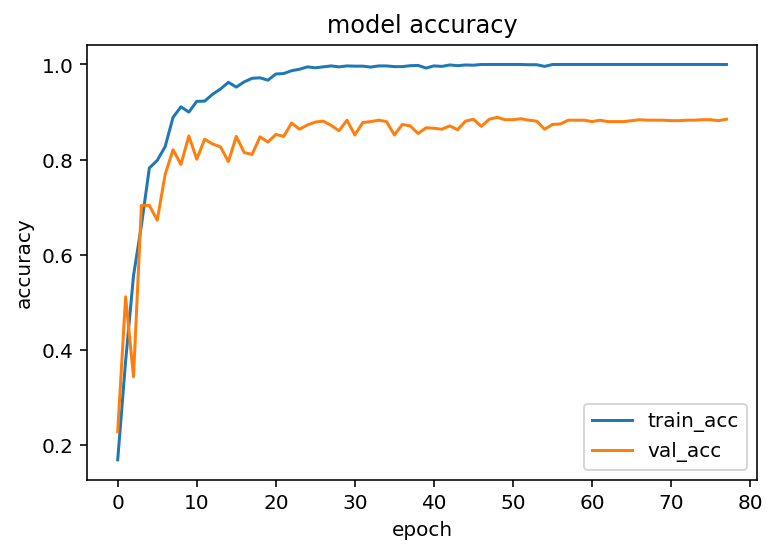

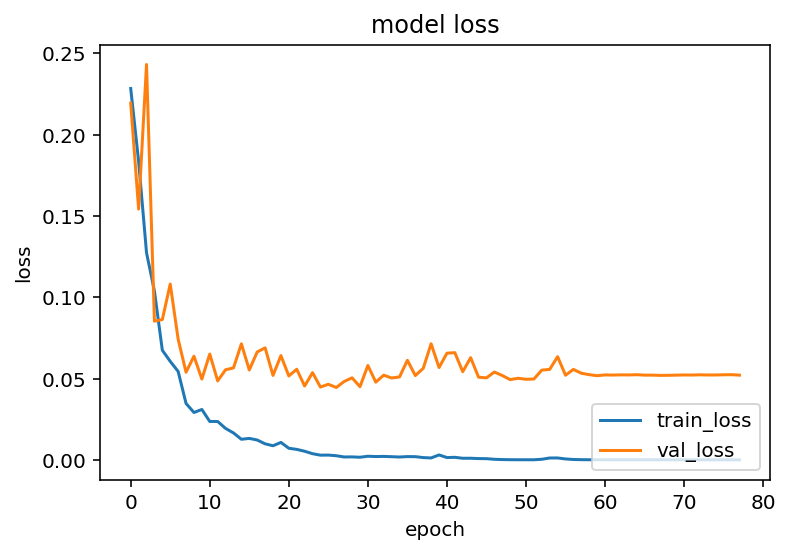

100%|██████████| 57/57 [00:06<00:00,  9.25it/s]
[2017-12-05 03:08:50,886 INFO] Epoch: 0 | TrainAcc: 0.1860 | TrainLoss: 0.2319
[2017-12-05 03:08:51,233 INFO] Epoch: 0 | ValAcc: 0.1800 | ValLoss: 0.2175 

[2017-12-05 03:08:52,486 INFO] Epoch: 1 | TrainAcc: 0.3815 | TrainLoss: 0.1834
[2017-12-05 03:08:52,838 INFO] Epoch: 1 | ValAcc: 0.3890 | ValLoss: 0.1729 

[2017-12-05 03:08:54,144 INFO] Epoch: 2 | TrainAcc: 0.6180 | TrainLoss: 0.1216
[2017-12-05 03:08:54,499 INFO] Epoch: 2 | ValAcc: 0.5140 | ValLoss: 0.1407 

[2017-12-05 03:08:55,759 INFO] Epoch: 3 | TrainAcc: 0.7600 | TrainLoss: 0.0756
[2017-12-05 03:08:56,109 INFO] Epoch: 3 | ValAcc: 0.6680 | ValLoss: 0.0924 

[2017-12-05 03:08:57,388 INFO] Epoch: 4 | TrainAcc: 0.7865 | TrainLoss: 0.0633
[2017-12-05 03:08:57,744 INFO] Epoch: 4 | ValAcc: 0.7720 | ValLoss: 0.0657 

[2017-12-05 03:08:59,119 INFO] Epoch: 5 | TrainAcc: 0.8445 | TrainLoss: 0.0495
[2017-12-05 03:08:59,474 INFO] Epoch: 5 | ValAcc: 0.7470 | ValLoss: 0.0739 

[2017-12-05 03:0

[2017-12-05 03:10:19,779 INFO] Epoch: 51 | ValAcc: 0.9020 | ValLoss: 0.0396 

[2017-12-05 03:10:21,035 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:10:21,382 INFO] Epoch: 52 | ValAcc: 0.9020 | ValLoss: 0.0410 

[2017-12-05 03:10:22,648 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:10:22,993 INFO] Epoch: 53 | ValAcc: 0.9020 | ValLoss: 0.0404 

[2017-12-05 03:10:24,249 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:10:24,592 INFO] Epoch: 54 | ValAcc: 0.9050 | ValLoss: 0.0405 

[2017-12-05 03:10:25,942 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:10:26,319 INFO] Epoch: 55 | ValAcc: 0.9020 | ValLoss: 0.0401 

[2017-12-05 03:10:27,853 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:10:28,214 INFO] Epoch: 56 | ValAcc: 0.9030 | ValLoss: 0.0403 

[2017-12-05 03:10:29,637 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:10:30,013 INFO] Epoch: 57 | ValAcc: 0

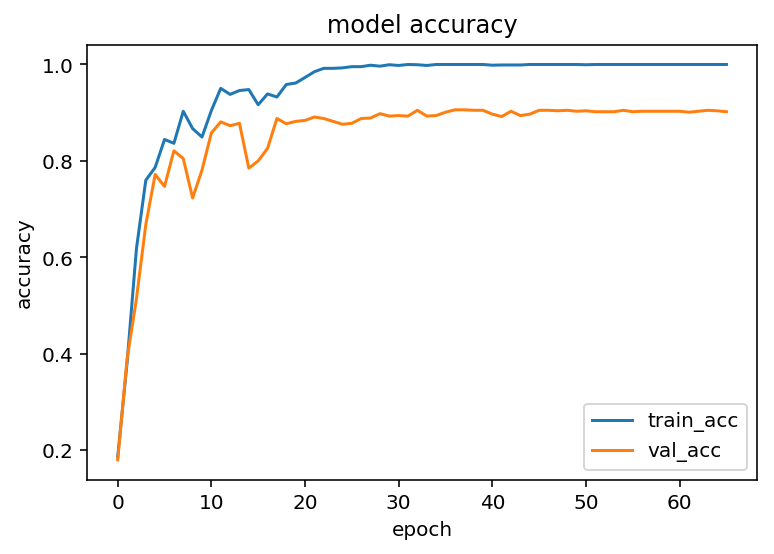

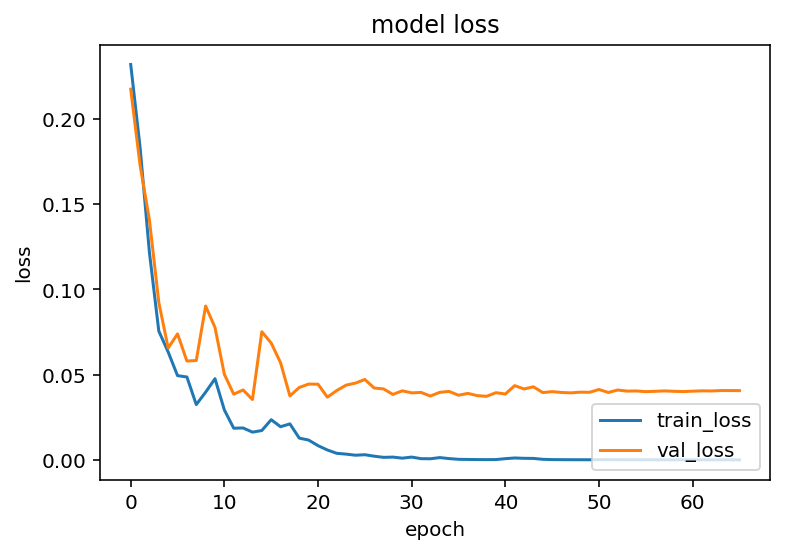

100%|██████████| 57/57 [00:06<00:00,  8.98it/s]
[2017-12-05 03:11:01,229 INFO] Epoch: 0 | TrainAcc: 0.1595 | TrainLoss: 0.2269
[2017-12-05 03:11:01,694 INFO] Epoch: 0 | ValAcc: 0.2590 | ValLoss: 0.2099 

[2017-12-05 03:11:03,042 INFO] Epoch: 1 | TrainAcc: 0.3695 | TrainLoss: 0.1845
[2017-12-05 03:11:03,394 INFO] Epoch: 1 | ValAcc: 0.3400 | ValLoss: 0.1750 

[2017-12-05 03:11:04,830 INFO] Epoch: 2 | TrainAcc: 0.5210 | TrainLoss: 0.1375
[2017-12-05 03:11:05,187 INFO] Epoch: 2 | ValAcc: 0.4660 | ValLoss: 0.1480 

[2017-12-05 03:11:06,645 INFO] Epoch: 3 | TrainAcc: 0.7060 | TrainLoss: 0.0914
[2017-12-05 03:11:07,021 INFO] Epoch: 3 | ValAcc: 0.7150 | ValLoss: 0.0860 

[2017-12-05 03:11:08,314 INFO] Epoch: 4 | TrainAcc: 0.7895 | TrainLoss: 0.0667
[2017-12-05 03:11:08,664 INFO] Epoch: 4 | ValAcc: 0.6400 | ValLoss: 0.1162 

[2017-12-05 03:11:10,079 INFO] Epoch: 5 | TrainAcc: 0.8445 | TrainLoss: 0.0505
[2017-12-05 03:11:10,489 INFO] Epoch: 5 | ValAcc: 0.8060 | ValLoss: 0.0598 

[2017-12-05 03:1

[2017-12-05 03:12:32,220 INFO] Epoch: 51 | ValAcc: 0.8770 | ValLoss: 0.0456 

[2017-12-05 03:12:33,682 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:12:34,071 INFO] Epoch: 52 | ValAcc: 0.8800 | ValLoss: 0.0464 

[2017-12-05 03:12:35,494 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:12:36,058 INFO] Epoch: 53 | ValAcc: 0.8810 | ValLoss: 0.0458 

[2017-12-05 03:12:37,511 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:12:37,898 INFO] Epoch: 54 | ValAcc: 0.8770 | ValLoss: 0.0464 

[2017-12-05 03:12:39,259 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:12:39,662 INFO] Epoch: 55 | ValAcc: 0.8780 | ValLoss: 0.0460 

[2017-12-05 03:12:41,096 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:12:41,472 INFO] Epoch: 56 | ValAcc: 0.8770 | ValLoss: 0.0465 

[2017-12-05 03:12:42,749 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:12:43,107 INFO] Epoch: 57 | ValAcc: 0

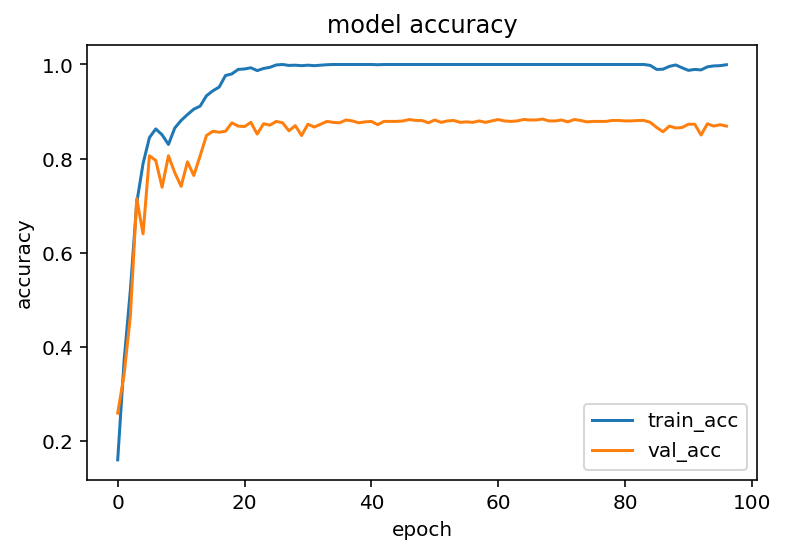

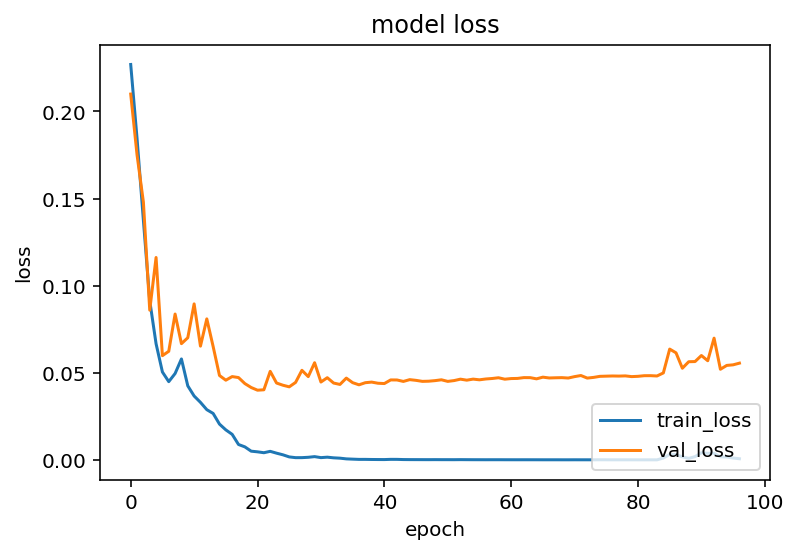

100%|██████████| 57/57 [00:06<00:00,  9.13it/s]
[2017-12-05 03:14:09,286 INFO] Epoch: 0 | TrainAcc: 0.1940 | TrainLoss: 0.2292
[2017-12-05 03:14:09,643 INFO] Epoch: 0 | ValAcc: 0.2130 | ValLoss: 0.2187 

[2017-12-05 03:14:10,971 INFO] Epoch: 1 | TrainAcc: 0.4030 | TrainLoss: 0.1847
[2017-12-05 03:14:11,336 INFO] Epoch: 1 | ValAcc: 0.3510 | ValLoss: 0.1697 

[2017-12-05 03:14:12,631 INFO] Epoch: 2 | TrainAcc: 0.5635 | TrainLoss: 0.1300
[2017-12-05 03:14:12,991 INFO] Epoch: 2 | ValAcc: 0.6100 | ValLoss: 0.1134 

[2017-12-05 03:14:14,342 INFO] Epoch: 3 | TrainAcc: 0.6825 | TrainLoss: 0.0924
[2017-12-05 03:14:14,699 INFO] Epoch: 3 | ValAcc: 0.6740 | ValLoss: 0.0957 

[2017-12-05 03:14:15,989 INFO] Epoch: 4 | TrainAcc: 0.7735 | TrainLoss: 0.0658
[2017-12-05 03:14:16,355 INFO] Epoch: 4 | ValAcc: 0.7650 | ValLoss: 0.0680 

[2017-12-05 03:14:17,663 INFO] Epoch: 5 | TrainAcc: 0.8030 | TrainLoss: 0.0594
[2017-12-05 03:14:18,021 INFO] Epoch: 5 | ValAcc: 0.7510 | ValLoss: 0.0791 

[2017-12-05 03:1

[2017-12-05 03:15:36,281 INFO] Epoch: 51 | ValAcc: 0.8990 | ValLoss: 0.0410 

[2017-12-05 03:15:37,566 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:15:37,939 INFO] Epoch: 52 | ValAcc: 0.8980 | ValLoss: 0.0419 

[2017-12-05 03:15:39,227 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:15:39,571 INFO] Epoch: 53 | ValAcc: 0.9000 | ValLoss: 0.0420 

[2017-12-05 03:15:41,070 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:15:41,572 INFO] Epoch: 54 | ValAcc: 0.9000 | ValLoss: 0.0410 

[2017-12-05 03:15:43,211 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:15:43,580 INFO] Epoch: 55 | ValAcc: 0.9000 | ValLoss: 0.0412 

[2017-12-05 03:15:44,878 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:15:45,235 INFO] Epoch: 56 | ValAcc: 0.9000 | ValLoss: 0.0416 

[2017-12-05 03:15:46,527 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:15:46,923 INFO] Epoch: 57 | ValAcc: 0

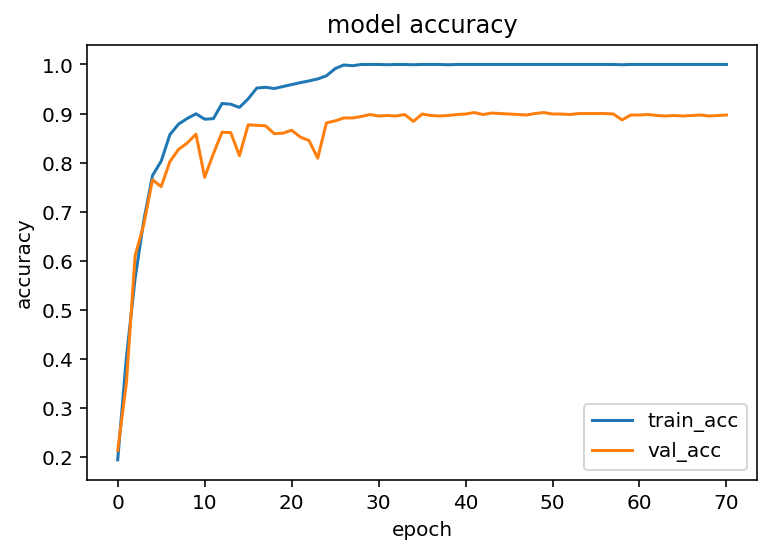

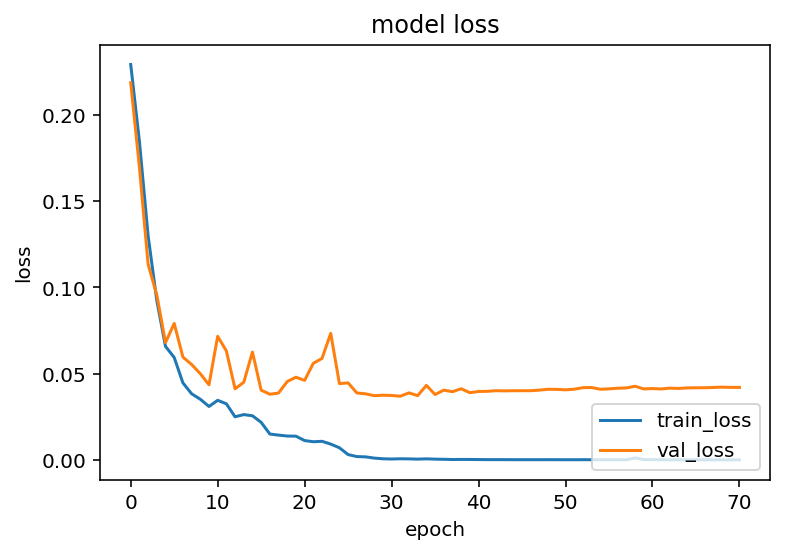

100%|██████████| 57/57 [00:06<00:00,  8.35it/s]
[2017-12-05 03:16:29,350 INFO] Epoch: 0 | TrainAcc: 0.1535 | TrainLoss: 0.2397
[2017-12-05 03:16:29,707 INFO] Epoch: 0 | ValAcc: 0.1530 | ValLoss: 0.2236 

[2017-12-05 03:16:31,059 INFO] Epoch: 1 | TrainAcc: 0.3335 | TrainLoss: 0.2026
[2017-12-05 03:16:31,533 INFO] Epoch: 1 | ValAcc: 0.3650 | ValLoss: 0.1897 

[2017-12-05 03:16:33,079 INFO] Epoch: 2 | TrainAcc: 0.5095 | TrainLoss: 0.1512
[2017-12-05 03:16:33,588 INFO] Epoch: 2 | ValAcc: 0.2340 | ValLoss: 0.2315 

[2017-12-05 03:16:34,943 INFO] Epoch: 3 | TrainAcc: 0.6160 | TrainLoss: 0.1163
[2017-12-05 03:16:35,293 INFO] Epoch: 3 | ValAcc: 0.5600 | ValLoss: 0.1334 

[2017-12-05 03:16:36,883 INFO] Epoch: 4 | TrainAcc: 0.7235 | TrainLoss: 0.0802
[2017-12-05 03:16:37,376 INFO] Epoch: 4 | ValAcc: 0.6980 | ValLoss: 0.0888 

[2017-12-05 03:16:39,006 INFO] Epoch: 5 | TrainAcc: 0.8120 | TrainLoss: 0.0598
[2017-12-05 03:16:39,480 INFO] Epoch: 5 | ValAcc: 0.8120 | ValLoss: 0.0571 

[2017-12-05 03:1

[2017-12-05 03:18:07,369 INFO] Epoch: 51 | ValAcc: 0.8990 | ValLoss: 0.0472 

[2017-12-05 03:18:08,852 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:18:09,303 INFO] Epoch: 52 | ValAcc: 0.8970 | ValLoss: 0.0474 

[2017-12-05 03:18:10,904 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:18:11,378 INFO] Epoch: 53 | ValAcc: 0.8960 | ValLoss: 0.0472 

[2017-12-05 03:18:12,781 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:18:13,231 INFO] Epoch: 54 | ValAcc: 0.8960 | ValLoss: 0.0473 

[2017-12-05 03:18:14,884 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:18:15,433 INFO] Epoch: 55 | ValAcc: 0.8960 | ValLoss: 0.0477 

[2017-12-05 03:18:16,968 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:18:17,409 INFO] Epoch: 56 | ValAcc: 0.8990 | ValLoss: 0.0473 

[2017-12-05 03:18:18,953 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:18:19,397 INFO] Epoch: 57 | ValAcc: 0

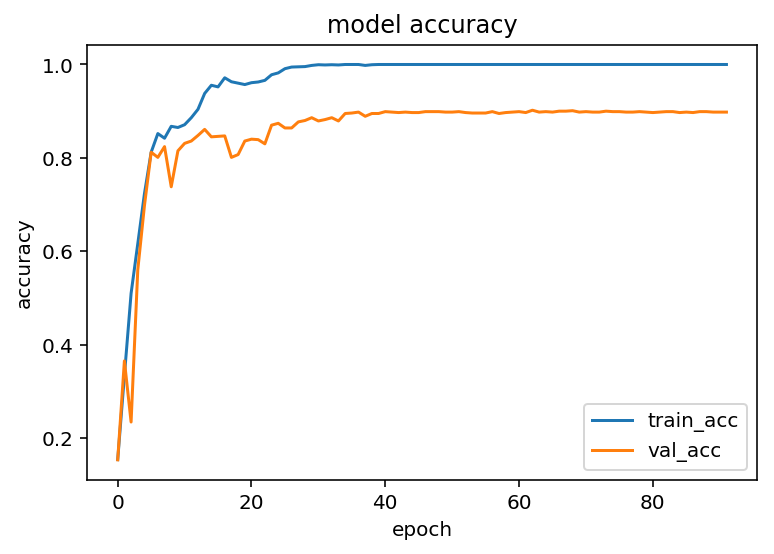

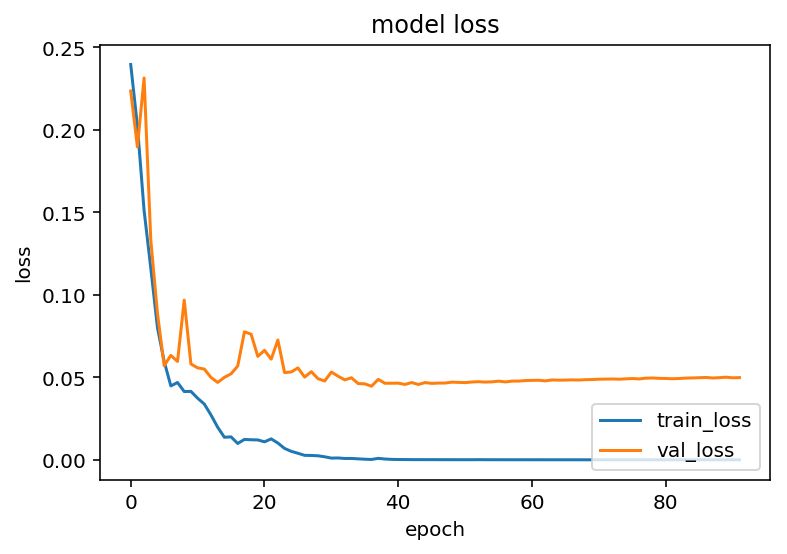

100%|██████████| 57/57 [00:06<00:00,  8.65it/s]
[2017-12-05 03:19:41,067 INFO] Epoch: 0 | TrainAcc: 0.1560 | TrainLoss: 0.2426
[2017-12-05 03:19:41,463 INFO] Epoch: 0 | ValAcc: 0.2470 | ValLoss: 0.2274 

[2017-12-05 03:19:42,811 INFO] Epoch: 1 | TrainAcc: 0.3120 | TrainLoss: 0.2053
[2017-12-05 03:19:43,205 INFO] Epoch: 1 | ValAcc: 0.2460 | ValLoss: 0.1941 

[2017-12-05 03:19:44,549 INFO] Epoch: 2 | TrainAcc: 0.4350 | TrainLoss: 0.1517
[2017-12-05 03:19:44,921 INFO] Epoch: 2 | ValAcc: 0.4260 | ValLoss: 0.1424 

[2017-12-05 03:19:46,706 INFO] Epoch: 3 | TrainAcc: 0.5795 | TrainLoss: 0.1148
[2017-12-05 03:19:47,100 INFO] Epoch: 3 | ValAcc: 0.4870 | ValLoss: 0.1516 

[2017-12-05 03:19:48,678 INFO] Epoch: 4 | TrainAcc: 0.6845 | TrainLoss: 0.0915
[2017-12-05 03:19:49,086 INFO] Epoch: 4 | ValAcc: 0.6740 | ValLoss: 0.0877 

[2017-12-05 03:19:50,786 INFO] Epoch: 5 | TrainAcc: 0.7505 | TrainLoss: 0.0753
[2017-12-05 03:19:51,200 INFO] Epoch: 5 | ValAcc: 0.6890 | ValLoss: 0.0920 

[2017-12-05 03:1

[2017-12-05 03:21:16,258 INFO] Epoch: 51 | ValAcc: 0.8920 | ValLoss: 0.0451 

[2017-12-05 03:21:17,749 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:21:18,214 INFO] Epoch: 52 | ValAcc: 0.8950 | ValLoss: 0.0453 

[2017-12-05 03:21:19,841 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:21:20,272 INFO] Epoch: 53 | ValAcc: 0.8930 | ValLoss: 0.0453 

[2017-12-05 03:21:21,925 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:21:22,315 INFO] Epoch: 54 | ValAcc: 0.8940 | ValLoss: 0.0454 

[2017-12-05 03:21:23,802 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:21:24,253 INFO] Epoch: 55 | ValAcc: 0.8940 | ValLoss: 0.0453 

[2017-12-05 03:21:25,655 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:21:26,081 INFO] Epoch: 56 | ValAcc: 0.8930 | ValLoss: 0.0453 

[2017-12-05 03:21:27,495 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:21:27,864 INFO] Epoch: 57 | ValAcc: 0

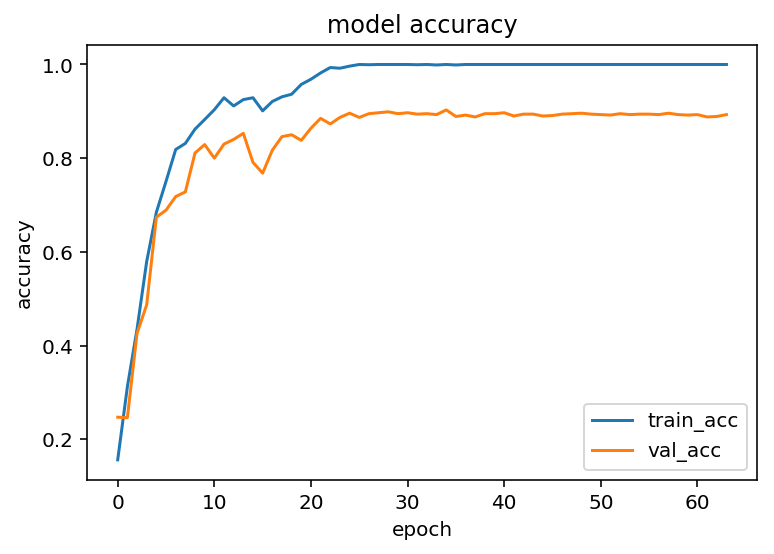

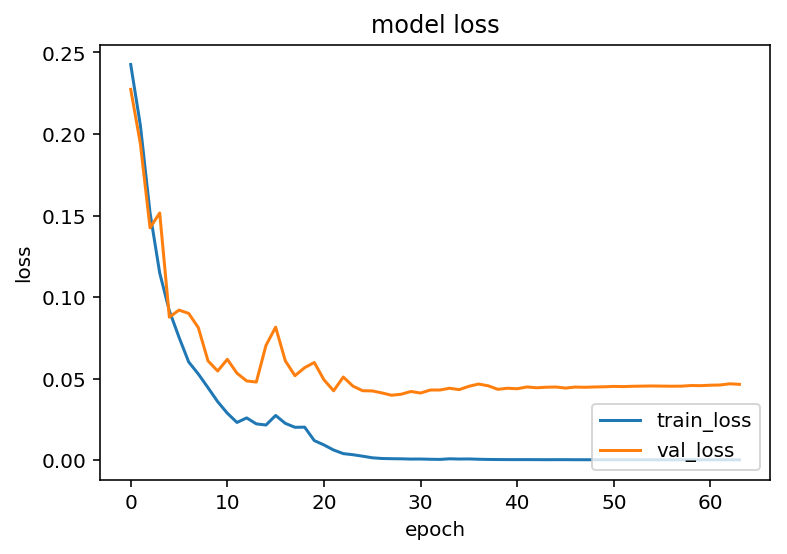

100%|██████████| 57/57 [00:06<00:00,  9.37it/s]
[2017-12-05 03:21:54,274 INFO] Epoch: 0 | TrainAcc: 0.1505 | TrainLoss: 0.2342
[2017-12-05 03:21:54,611 INFO] Epoch: 0 | ValAcc: 0.1090 | ValLoss: 0.2237 

[2017-12-05 03:21:55,840 INFO] Epoch: 1 | TrainAcc: 0.3495 | TrainLoss: 0.1992
[2017-12-05 03:21:56,204 INFO] Epoch: 1 | ValAcc: 0.4180 | ValLoss: 0.1816 

[2017-12-05 03:21:57,453 INFO] Epoch: 2 | TrainAcc: 0.4655 | TrainLoss: 0.1551
[2017-12-05 03:21:57,808 INFO] Epoch: 2 | ValAcc: 0.4450 | ValLoss: 0.1664 

[2017-12-05 03:21:59,032 INFO] Epoch: 3 | TrainAcc: 0.5710 | TrainLoss: 0.1261
[2017-12-05 03:21:59,373 INFO] Epoch: 3 | ValAcc: 0.5030 | ValLoss: 0.1617 

[2017-12-05 03:22:00,600 INFO] Epoch: 4 | TrainAcc: 0.6535 | TrainLoss: 0.0957
[2017-12-05 03:22:00,947 INFO] Epoch: 4 | ValAcc: 0.5110 | ValLoss: 0.1416 

[2017-12-05 03:22:02,180 INFO] Epoch: 5 | TrainAcc: 0.7580 | TrainLoss: 0.0721
[2017-12-05 03:22:02,518 INFO] Epoch: 5 | ValAcc: 0.6950 | ValLoss: 0.0934 

[2017-12-05 03:2

[2017-12-05 03:23:15,879 INFO] Epoch: 51 | ValAcc: 0.8840 | ValLoss: 0.0494 

[2017-12-05 03:23:17,150 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:23:17,493 INFO] Epoch: 52 | ValAcc: 0.8800 | ValLoss: 0.0499 

[2017-12-05 03:23:18,740 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:23:19,083 INFO] Epoch: 53 | ValAcc: 0.8820 | ValLoss: 0.0493 

[2017-12-05 03:23:20,313 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-05 03:23:20,660 INFO] Epoch: 54 | ValAcc: 0.8820 | ValLoss: 0.0500 

[2017-12-05 03:23:21,903 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:23:22,243 INFO] Epoch: 55 | ValAcc: 0.8840 | ValLoss: 0.0494 

[2017-12-05 03:23:23,622 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:23:23,989 INFO] Epoch: 56 | ValAcc: 0.8830 | ValLoss: 0.0499 

[2017-12-05 03:23:25,324 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-05 03:23:25,686 INFO] Epoch: 57 | ValAcc: 0

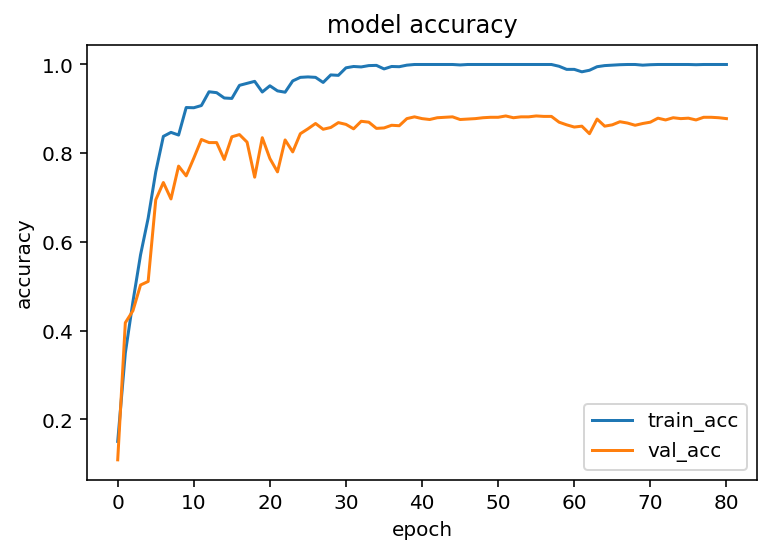

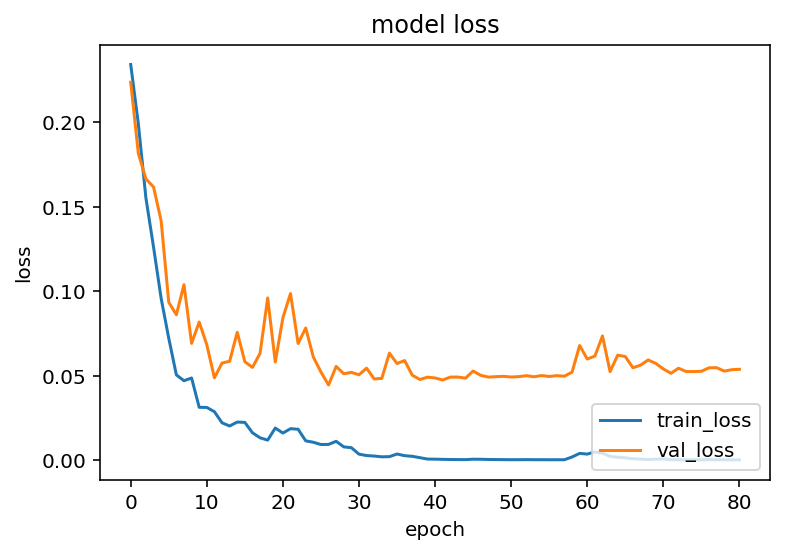

100%|██████████| 57/57 [00:05<00:00,  9.75it/s]


In [47]:
# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
ratio_pl = 1.0 # ratio of train:pseudo
hard = True
ex_name = 'cross_pseudo'
trial_times = 10

y_pseudo = np.load('./save/pseudo_label_supervised.npy')

logzero.logfile('./log/{}.log'.format(ex_name))

def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
    torch.save(state, filename)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

results1 = {}
results1['test_acc'] = np.empty((trial_times))
results1['test_loss'] = np.empty((trial_times))
results1['unlabeled_acc'] = np.empty((trial_times))
results1['unlabeled_loss'] = np.empty((trial_times))
results1['non_used_acc'] = np.empty((trial_times))
results1['non_used_loss'] = np.empty((trial_times))

results2 = {}
results2['test_acc'] = np.empty((trial_times))
results2['test_loss'] = np.empty((trial_times))
results2['unlabeled_acc'] = np.empty((trial_times))
results2['unlabeled_loss'] = np.empty((trial_times))
results2['non_used_acc'] = np.empty((trial_times))
results2['non_used_loss'] = np.empty((trial_times))

for i in range(trial_times):
    
    #=========Fold-1=========#
    y_pseudo1 = y_pseudo[idx1]
    
    train_dataset = MNISTDatasetForPseudoLabeling(
        X_train, y_train, X_unlabeled1, y_pseudo1, ratio_pl, hard, transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_dataset = MNISTDataset(X_val, y_val, transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch_size, num_workers=num_workers)
    test_dataset = MNISTDataset(X_test, y_test, transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, num_workers=num_workers)
    unlabeled_dataset = MNISTDataset(X_unlabeled1, y_unlabeled1, transform)
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset, batch_size=test_batch_size, num_workers=num_workers)
    unlabeled_non_used_dataset = MNISTDataset(X_unlabeled2, y_unlabeled2, transform)
    unlabeled_non_used_loader = torch.utils.data.DataLoader(
        unlabeled_non_used_dataset, batch_size=test_batch_size, num_workers=num_workers)

    model = Net()
    if use_gpu:
        model.cuda()

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch

        _train(model, train_loader, criterion, optimizer, tracker)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results1['test_acc'][i], results1['test_loss'][i] = _test(model, test_loader, criterion)
    results1['unlabeled_acc'][i], results1['unlabeled_loss'][i] = \
        _test(model, unlabeled_loader, criterion)
    results1['non_used_acc'][i], results1['non_used_loss'][i] = \
        _test(model, unlabeled_non_used_loader, criterion)
        
    #=========Fold-2=========#
    
    y_pseudo2 = y_pseudo[idx2]
    
    train_dataset = MNISTDatasetForPseudoLabeling(
        X_train, y_train, X_unlabeled2, y_pseudo2, ratio_pl, hard, transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_dataset = MNISTDataset(X_val, y_val, transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch_size, num_workers=num_workers)
    test_dataset = MNISTDataset(X_test, y_test, transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, num_workers=num_workers)
    unlabeled_dataset = MNISTDataset(X_unlabeled2, y_unlabeled2, transform)
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset, batch_size=test_batch_size, num_workers=num_workers)
    unlabeled_non_used_dataset = MNISTDataset(X_unlabeled1, y_unlabeled1, transform)
    unlabeled_non_used_loader = torch.utils.data.DataLoader(
        unlabeled_non_used_dataset, batch_size=test_batch_size, num_workers=num_workers)

    model = Net()
    if use_gpu:
        model.cuda()

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch

        _train(model, train_loader, criterion, optimizer, tracker)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results2['test_acc'][i], results2['test_loss'][i] = _test(model, test_loader, criterion)
    results2['unlabeled_acc'][i], results2['unlabeled_loss'][i] = \
        _test(model, unlabeled_loader, criterion)
    results2['non_used_acc'][i], results2['non_used_loss'][i] = \
        _test(model, unlabeled_non_used_loader, criterion)

In [48]:
logger.info('Fold-1 result\n')
logger.info('Test Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results1['test_acc']),
    np.std(results1['test_acc'])
))
logger.info('Test Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results1['test_loss']),
    np.std(results1['test_loss'])
))

logger.info('Unlabeled Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results1['unlabeled_acc']),
    np.std(results1['unlabeled_acc'])
))
logger.info('Unlabeled Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results1['unlabeled_loss']),
    np.std(results1['unlabeled_loss'])
))

logger.info('Unlabeled(Non-Used) Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results1['non_used_acc']),
    np.std(results1['non_used_acc'])
))
logger.info('Unlabeled(Non-Used) Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results1['non_used_loss']),
    np.std(results1['non_used_loss'])
))

[2017-12-05 03:24:19,931 INFO] Fold-1 result

[2017-12-05 03:24:19,934 INFO] Test Accuracy: 0.9099 ± 0.0067
[2017-12-05 03:24:19,937 INFO] Test Loss: 0.0360 ± 0.0033

[2017-12-05 03:24:19,940 INFO] Unlabeled Accuracy: 0.9033 ± 0.0059
[2017-12-05 03:24:19,942 INFO] Unlabeled Loss: 0.0394 ± 0.0037

[2017-12-05 03:24:19,943 INFO] Unlabeled(Non-Used) Accuracy: 0.9010 ± 0.0055
[2017-12-05 03:24:19,945 INFO] Unlabeled(Non-Used) Loss: 0.0408 ± 0.0037


In [49]:
logger.info('Fold-2 result\n')
logger.info('Test Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results2['test_acc']),
    np.std(results2['test_acc'])
))
logger.info('Test Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results2['test_loss']),
    np.std(results2['test_loss'])
))

logger.info('Unlabeled Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results2['unlabeled_acc']),
    np.std(results2['unlabeled_acc'])
))
logger.info('Unlabeled Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results2['unlabeled_loss']),
    np.std(results2['unlabeled_loss'])
))

logger.info('Unlabeled(Non-Used) Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results2['non_used_acc']),
    np.std(results2['non_used_acc'])
))
logger.info('Unlabeled(Non-Used) Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results2['non_used_loss']),
    np.std(results2['non_used_loss'])
))

[2017-12-05 03:24:20,027 INFO] Fold-2 result

[2017-12-05 03:24:20,029 INFO] Test Accuracy: 0.9023 ± 0.0108
[2017-12-05 03:24:20,031 INFO] Test Loss: 0.0391 ± 0.0031

[2017-12-05 03:24:20,033 INFO] Unlabeled Accuracy: 0.8942 ± 0.0100
[2017-12-05 03:24:20,035 INFO] Unlabeled Loss: 0.0446 ± 0.0031

[2017-12-05 03:24:20,036 INFO] Unlabeled(Non-Used) Accuracy: 0.8963 ± 0.0101
[2017-12-05 03:24:20,042 INFO] Unlabeled(Non-Used) Loss: 0.0422 ± 0.0034


In [ ]:
from scipy import stats

t, p = stats.ttest_ind(results['test_acc'], results['unlabeled_acc'], equal_var=False)
print( "p値 = %(p)s" %locals() )